# AIML Assignment 2: Time Series Analysis on Pollutant Gases
## Problem Statement
![Air Pollution](https://assets.nrdc.org/sites/default/files/styles/header_background/public/health4_26_airpollguide_istock_2796602_900x600px.jpg?itok=vCwn8tgz)

Air pollution is a problem that affects major cities around the world. There are many different types of air pollutants, which usually come in the form of gases like carbon monoxide, carbon dioxide, sulfur dioxide, nitrogen oxides, CFCss, and other chemicals. 

Bad air quality in cities can lead to health problems for residents living there, including respiratory diseases and even death. In fact, according to the World Health Organisation, air pollution accounts for 4.2 million deaths every year [[1]](https://www.who.int/health-topics/air-pollution#tab=tab_1). To keep track of air pollution, governments invest heavily in sensors, which are used to measure the level of air pollution of different pollutants. However, good quality sensors are expensive, and thus governments rely on cheap sensors which have low accuracy. [[2]](https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=5536&context=sis_research)

Our task is to create a time series model that is capable of forecasting air pollution levels. If our model can forecast air pollution data with a reasonable accuracy, it would be a valuable tool (more accurate than low quality sensors) for health authorities to guage the impact of air pollution, and warn the public of any health threats. 

To be more concrete, our task is to predict the average sensor response of Carbon Monoxide, Non Metanic HydroCarbons, Nitrogen Oxides, and Ozone. (Note that sensor response is not the same as the concentration.)

### Carbon Monoxide (CO)
Carbon monoxide (CO)—a colorless, odorless, tasteless, and toxic air pollutant—is produced in the incomplete combustion of carbon-containing fuels, such as gasoline, natural gas, oil, coal, and wood. Breathing the high concentrations of CO typical of a polluted environment leads to reduced oxygen (O2) transport by hemoglobin and has health effects that include headaches, increased risk of chest pain for persons with heart disease, and impaired reaction timing. [[3]](https://www.nap.edu/read/10378/chapter/3)

## Data Understanding
The dataset appears to be sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality), but with data downsampled from an hourly frequency to a daily frequency, and several features omitted. The description and date range of the data appears to match up, the scales of the data are the same,and even the method of marking missing values is the same. Furthermore, downsampling that dataset leads to a dataset that has a similar size as the one provided. 

If we make an assumption that the data set is the same, we can say that the data was collected from chemical sensor data collected over the course of March 2004 to February 2005. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub)

![Operation of a MOS Type Gas Sensor](https://www.figaro.co.jp/en/img/development/handoutai/shikumi.gif)

The sensors used are metal oxide sensors, which use a sensing layer, where gases are either absorbed or desorbed. This reaction causes a change in the conductivity of the material. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub). The sensor device then uses this reading to estimate the concentration of that particular gas in the surroundings.

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants. Note that the concentration for Carbon Monoxide would be in a different unit |

Our target attribute would be the `Value` attribute.
## References
- AIML Module Notes
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. 
- Statsmodels Documentation
- Pandas documentation
- Scikit Learn documentation
- Wiley Data Analyst Time Series and Forecasting Notes
- [World Health Organisation](https://www.who.int/health-topics/air-pollution#tab=tab_1)
- MAAH, Balz; ZHOU, Zimu; and THIELE, Lothar. A survey on sensor calibration in air pollution monitoring 
deployments. (2018). IEEE Internet of Things. 5, (6), 4857-4870. Research Collection School Of 
Information Systems. 
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
- [S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia,
On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario](https://www.researchgate.net/publication/235641830_On_field_calibration_of_an_electronic_nose_for_benzene_estimation_in_an_urban_pollution_monitoring_scenario)
- [Climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy)
- [Nitrogen Oxide Emission Trends for Italy](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- [NOx Emissions - European Environment Agency](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)
- [Effect of Environmental Temperature and Humidity
on Different Metal Oxide Gas Sensors at Various
Gas Concentration Levels, Abdulnasser Nabil Abdullah et al 2020 IOP Conf. Ser.: Mater. Sci. Eng. 864
012152](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf)
- [Choosing the order of an ARIMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html#the-acf-and-pacf-function)
- [Using Pearson Correlation Correctly With Time Series](https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series)

## Library Imports

In [132]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models

# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion
We will start out by loading in our data. We must take note here that the date formatting of the data does not follow the standard Pandas convention. As such, we must specify the date formatting to convert the date attribute to a datetime.

Since many Pandas time series methods only work if the index of our data is a time series, we will set the date attribute as the index.

Also, we will set all -200 values as missing values, as specified in the dataset source.

In [133]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df.head()

T         RH Gas        Value
Date                                             
2004-03-10  12.020833  54.883334  CO  1316.500000
2004-03-11   9.833333  64.069791  CO  1244.062500
2004-03-12  11.292708  51.107292  CO  1281.562500
2004-03-13  12.866319  51.530903  CO  1330.555556
2004-03-14  16.016667  48.843750  CO  1360.927083

### Pivoting from Long to Wide Format
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row.

In [134]:
df_pivot = pd.pivot(df, values="Value", columns="Gas")
df_pivot[["T", "RH"]] = df[["T", "RH"]].groupby(df.index).mean()

## Exploratory Data Analysis

We then perform an exploratory data analysis of our data. 

### What do we want to find out?
#### General Dataset Information
- How many rows of data are there?
- What is the frequency of the time series data?
- How many features are there, and what do they mean?
- What are the data types of each attribute, and are they correctly represented?

#### Missing Values
- How many missing values are there?
- Why are there missing values?
- What should be done about the missing values?

#### Distribution of Data
- What does the distribution of our data look like, and what does it say about the data?

#### Outlier Analysis
- How many outliers are there in the data?
- Where are the outliers in the data?
- What should be done about outliers?
#### Correlation
- What are the relationships between the various variables?

#### Time Series

- What can be said about the trend and seasonality of the data?
- Is the data stationary?

### General Dataset Information

#### How many rows of data are there?

In [135]:
rows, cols = df.shape
print(f"There are {rows} rows and {cols} attributes in the dataset.")

There are 1312 rows and 4 attributes in the dataset.


In [136]:
rows, cols = df_pivot.shape
print(f"There are {rows} rows and {cols} attributes in the pivoted dataset.")

There are 328 rows and 6 attributes in the pivoted dataset.


#### What is the frequency of the time series data?

In [137]:
df_pivot.index

DatetimeIndex(['2004-03-10', '2004-03-11', '2004-03-12', '2004-03-13',
               '2004-03-14', '2004-03-15', '2004-03-16', '2004-03-17',
               '2004-03-18', '2004-03-19',
               ...
               '2005-01-22', '2005-01-23', '2005-01-24', '2005-01-25',
               '2005-01-26', '2005-01-27', '2005-01-28', '2005-01-29',
               '2005-01-30', '2005-01-31'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

There is not explicitly stated frequency. However, we suspect it is daily. We will need to verify this.

In [138]:
len(df_pivot) - len(df_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency.

In [139]:
df_pivot = df_pivot.asfreq("D") # explicitly state a daily frequency

#### How many features are there and what do they mean?

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants in micrograms/milligrams per cubic meter. Note that the concentration for Carbon Monoxide would be in a different unit (milligrams) |

#### What are the data types of each attribute, and are they correctly represented?

In [140]:
df.dtypes

T        float64
RH       float64
Gas       object
Value    float64
dtype: object

We observe no irregularities with regards to the data type.

### Missing Values

#### How many missing values are there?

In [141]:
df.isna().sum()

T        24
RH       24
Gas       0
Value    24
dtype: int64

In [142]:
df_pivot.isna().sum()

Gas
CO      6
NMHC    6
NOx     6
O3      6
T       6
RH      6
dtype: int64

In [143]:
df_pivot.isna().all(axis=1).sum()

6

It appears that there are exactly six days, where all the attributes are missing.

In [144]:
(df_pivot.isna().all(axis=1).sum() / len(df_pivot)) * 100

1.8292682926829267

This constitutes a very small percentage of our data.

#### Why are there missing values?

In [145]:
df_pivot[df_pivot.isna().any(axis=1)]

Gas         CO  NMHC  NOx  O3   T  RH
Date                                 
2004-06-20 NaN   NaN  NaN NaN NaN NaN
2004-08-27 NaN   NaN  NaN NaN NaN NaN
2004-12-15 NaN   NaN  NaN NaN NaN NaN
2004-12-16 NaN   NaN  NaN NaN NaN NaN
2005-01-03 NaN   NaN  NaN NaN NaN NaN
2005-01-04 NaN   NaN  NaN NaN NaN NaN

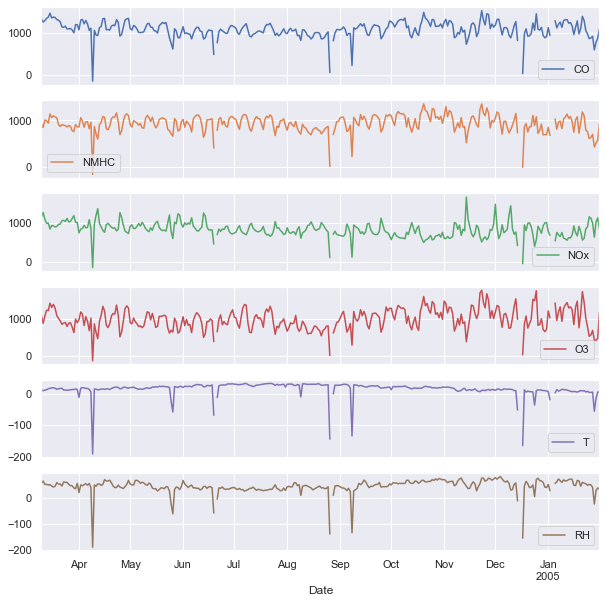

In [146]:
df_pivot.plot(subplots=True, figsize=(10, 10))
plt.show()

We note that days where the missing values do not appear to be related. For some of the days with missing values, we note that the days before and after them have some extreme values, such as extreme spikes.

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

#### What should be done about missing values?

Based on our hypothesis, if the missing values are due to problems with the sensors that were detected, it may not be a good idea to immediately fill the missing values with the previous value, as it may be an outlier value.

Possible methods:
- Front fill, but mark and deal with outliers first

### Distribution of Data

#### What does the distribution of our data look like, and what does it say about the data?

In [147]:
df_pivot.describe()

Gas             CO         NMHC          NOx           O3           T  \
count   322.000000   322.000000   322.000000   322.000000  322.000000   
mean   1074.034862   932.706457   831.478477   997.677396   15.578425   
std     192.346012   184.942814   200.428180   287.769529   23.412864   
min    -142.666667  -153.458333  -155.583333  -143.697917 -191.164583   
25%     981.338542   839.421875   712.370660   809.098958   12.627083   
50%    1084.482639   948.649306   826.208333  1005.692708   18.993750   
75%    1188.539062  1061.109375   944.387153  1183.658854   25.714149   
max    1513.208333  1355.104167  1678.687500  1795.291667   32.997917   

Gas            RH  
count  322.000000  
mean    44.343425  
std     28.487081  
min   -188.839583  
25%     37.101042  
50%     46.452083  
75%     58.028386  
max     81.104167

- The mean temperature recorded is 15.57 Degrees Celcius, but the min temperature -191.164 degrees celcius. This appears to be an extreme outlier.
- The median temperature is higher than the mean temperature, suggesting a negatively skewed distribution.
- The temperatures seen are mostly consistent with the [climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy). This suggests that the temperatures with extreme negative values are actually outliers (possibly sensor miscalibrations), and not the result of extreme cooling in the sensor device.
- The mean relative humidity is 44.34%, which is lower than the median relative humidity. This might suggest a negatively skewed distribution of the data.
- If relative humidity is in percentage, having a negative percentage relative humidity does not make sense. Consider that relative humidity is the **ratio of how much water vapour is in the air and how much water vapor the air could possibly contain at a given temperature**; How is it possible then that it is negative? Logically this must be an error (again, possibly a result of faulty sensors), and any negative values for Relative Humidity should be removed.
- Furthermore, according to the researchers who collected the data, the sensors used are only rated for a temperature of -20 to 50 degrees celcius, and a relative humidity of 10% to 90%. Hence, it is safe to consider any values out of this range as being inaccurate anyways.

![sensor specifications](sensor_specifications.png)

- In our data, we see that there are negative values for each gas as their min estimated concentration
- Recall that for the metal oxide sensors used to collect this data, we get these readings by measuring the change in resistance of the metal oxide material due to a chemical reaction between the metal oxide and the gas and using it to estimate the concentration of pollutants. Thus the "value" attribute in our data is supposed to be an estimated concentration in $\mu/m^3$ (for Nitrogen Oxides and Ozone), or $mg/m^3$ (for Carbon Monoxide)
- As such, a negative concentration does not make any sense. Given that the sensor is only giving a rough estimate of the concentration, it is highly possible that these negative values came about due to sensor errors. 
- The mean values are similar to their median, suggesting that the distribution is not highly skewed; The only outliers come from the negative values.
- Since the values are technically in different units, we may also want to perform scaling of our data.

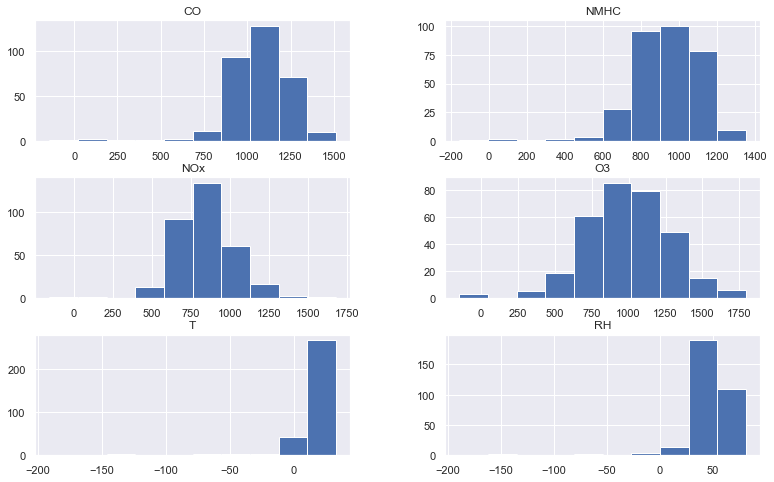

In [148]:
df_pivot.hist()
plt.show()

- We observe that the distribution of Temperature and Relative Humidity is negatively skewed, due to the outlier values
- The distribution of NOx and O3 appear to be more symmetrical
- Distribution of CO and NMHC is more negatively skewed, due to there being some outlier values.

### Outlier Analysis

From our previous analysis, we noted the presense of outliers in all numerical features. We had already come to a few conclusions based on our background research:
- These values are unnatural, and are impossible occurances in real life:
    - The freezing outlier temps are too cold for Italy's, and even too cold for the Artic
    - It is impossible for relative humidity to be negative
    - The sensors used to collect the data, are not rated for these extreme outlier temperatures/humdity
    - A negative concentration (which is what the sensors are trying to estimate), is also ridiculous. 
- Thus, we hypothesise that these come as a result of sensor calibration errors, resulting in a wrong sensor reading.

To test this hypothesis, we want to answer a few questions:
1. How many of these extreme outliers are there?
2. When do these outliers happen? Do they happen indepedently, or is there some pattern to the outlier data?

For this, we will use Tukey's Fences to denote any outliers. Recall that by this criterion, an outlier is any data that founds outside the range $[Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)]$. We use Tukey's Fences, as this method is applicable to skewed data since it makes no distributional assumptions and it does not depend on a mean or standard 
deviation. In this case, we will look at the extreme outliers, setting $k=3$. We will also mark negative RH and Value as outliers, since in the context here, they are definitely wrong.

We also need to take note that for time series data, we cannot use future information to detect past outliers. Hence, we will detect outliers on a rolling basis.

In [149]:
df_outliers = df_pivot.copy(deep=True)

In [150]:
def mark_outliers(df, col, k=1.5, window=7):
    df_col = df[col].rolling(window)
    upper_quartile = df_col.quantile(.75)
    lower_quartile = df_col.quantile(.25)
    interquartille_range = upper_quartile - lower_quartile
    upper_fence = upper_quartile + (k * interquartille_range)
    lower_fence = lower_quartile - (k * interquartille_range)
    outliers = ~(df[col].between(lower_fence, upper_fence))
    return outliers

Our current outlier detection method also may miss out certain anomalies.

We want to ensure that any 'impossible' values are marked as outliers. These are values which could not possibly be 0, or are actually out of the operating range for the sensor, and thus the result may not be reliable.

In [151]:
additional_outlier_rules = {
        col : df_outliers[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
} | {
    "T" : (df_outliers['T'] < -20) | (df_outliers['T'] > 50),
    "RH" : (df_outliers['RH'] < 10) | (df_outliers['RH'] > 90)
}

In [152]:
for col in df_outliers.columns:
    outliers = mark_outliers(df_outliers, col, k=3, window=7) # 1 Week Window
    df_outliers[f'Outlier ({col})'] = (outliers) | (additional_outlier_rules[col])
    

In [153]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].any(axis=1).sum()

72

In [154]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].sum()

Gas
Outlier (CO)      43
Outlier (NMHC)    42
Outlier (NOx)     49
Outlier (O3)      41
Outlier (T)       57
Outlier (RH)      51
dtype: int64

There are 72 rows with at least one outlier in total. Since there are at least >40 outliers for each column, it suggests that most days with outliers have more than one attribute with an outlier.

#### Where are the outliers in the data?

In [155]:
def plot_outlier(df, col_name, ax):
    outliers = df_outliers[df_outliers[f'Outlier ({col_name})'] == True]
    print(f"Number of Outliers for {col}:", len(outliers))
    df_outliers.plot(y=col_name, title=f"Outlier Plot of {col_name}", ax = ax)
    ax.scatter(x=outliers.index, y=outliers[col_name], color='r')

Number of Outliers for CO: 43
Number of Outliers for NMHC: 42
Number of Outliers for NOx: 49
Number of Outliers for O3: 41
Number of Outliers for T: 57
Number of Outliers for RH: 51


C:\Users\tienc\AppData\Local\Temp/ipykernel_21244/3075534334.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



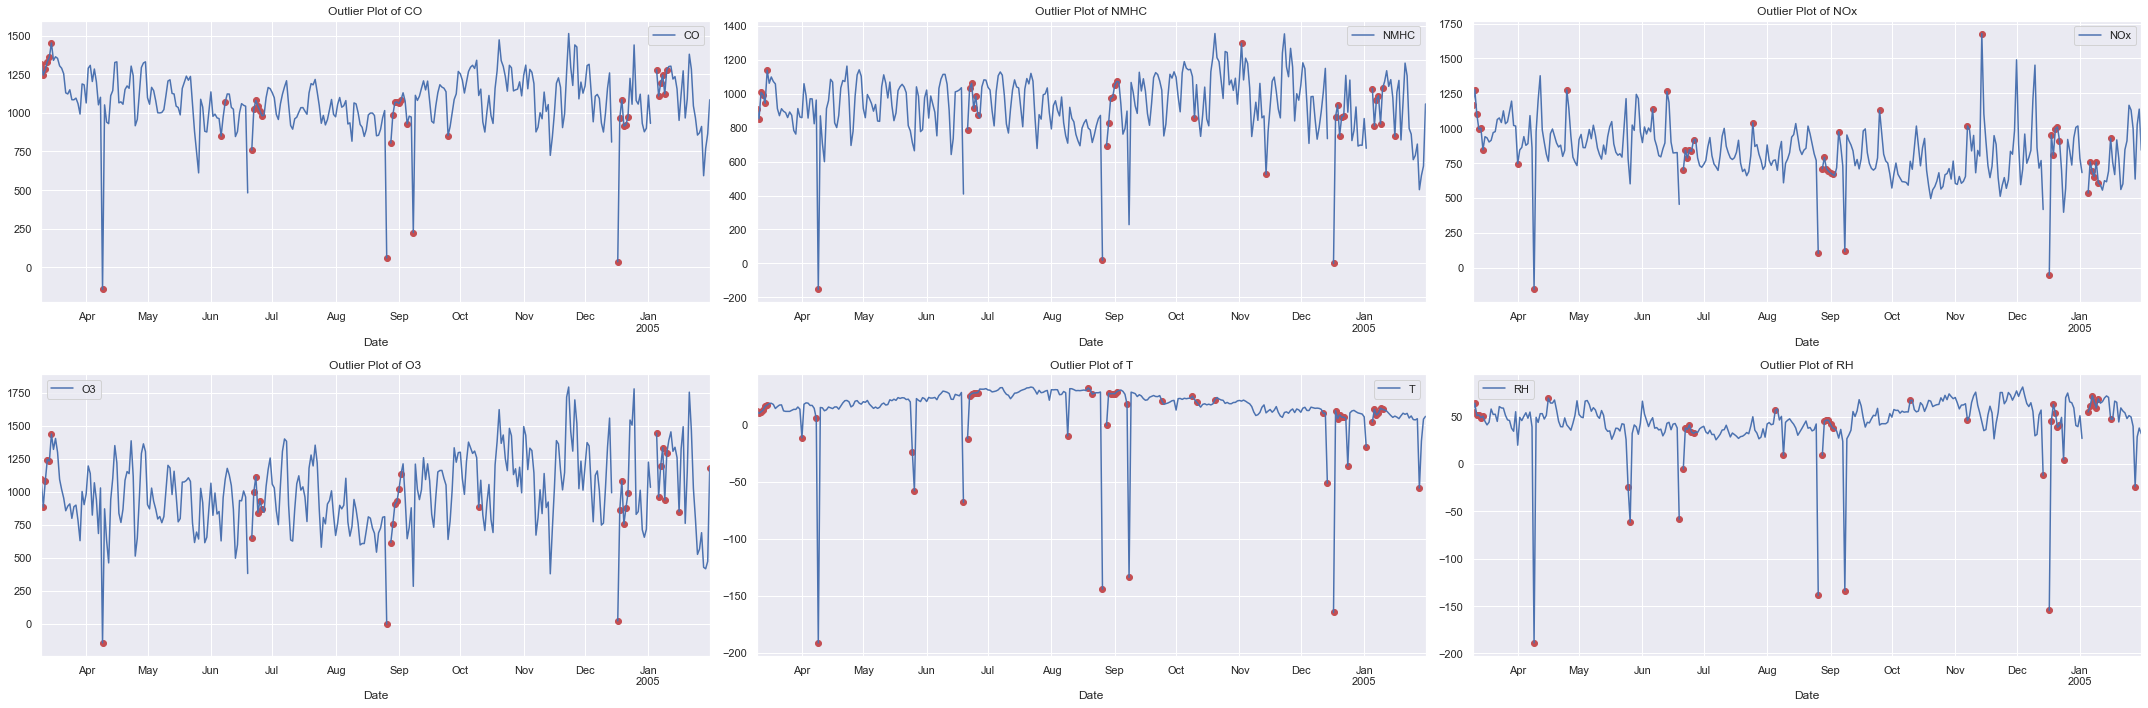

In [156]:
fig, axes = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)

for ax, col in zip(axes.ravel(), df_pivot.columns):
    plot_outlier(df_outliers, col, ax)

fig.show()

- We note that the detected outliers appear to happen at similar points in time to outliers in other features

#### What should be done about outliers?

According to [research](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf), when there are changes in the temperature and relative humidity, it causes a change in the resistance of the sensor, thus causing the readings to drift. This suggest that outside of the operating range of the sensors used (-20 to 50 degrees in Temp, and 10-90% relative humidity), the readings of the sensor would be less accurate. 

There are a few approaches we can take here:
- Ignore the outliers. But this is likely a bad idea, as at the very least, the outlier temperature and relative humidity are definitely wrong.
- Mark the outlier value, and  
    - Impute with the previous value
    - Impute with a rolling mean

For a start, we choose to ignore the extreme outliers, only cleaning the 'impossible' outliers first. Later on we will see what happens when extreme outliers are cleaned.

In [157]:
df_outliers.sum(axis=0)

Gas
CO                345839.225691
NMHC              300331.479173
NOx               267736.069443
O3                321252.121517
T                   5016.252777
RH                 14278.582988
Outlier (CO)          43.000000
Outlier (NMHC)        42.000000
Outlier (NOx)         49.000000
Outlier (O3)          41.000000
Outlier (T)           57.000000
Outlier (RH)          51.000000
dtype: float64

In [158]:
df_basic_clean = df_pivot.copy(deep=True)
for col in df_basic_clean.columns:
    outliers = additional_outlier_rules[col]
    df_basic_clean.loc[outliers, col] = np.nan
print("Before:", df_basic_clean.isna().sum())
df_basic_clean = df_basic_clean.ffill().bfill()
print("After:", df_basic_clean.isna().sum())


Before: Gas
CO       7
NMHC     8
NOx      8
O3       8
T       16
RH      19
dtype: int64
After: Gas
CO      0
NMHC    0
NOx     0
O3      0
T       0
RH      0
dtype: int64


### Correlation
#### What are the relationships between the various variables?

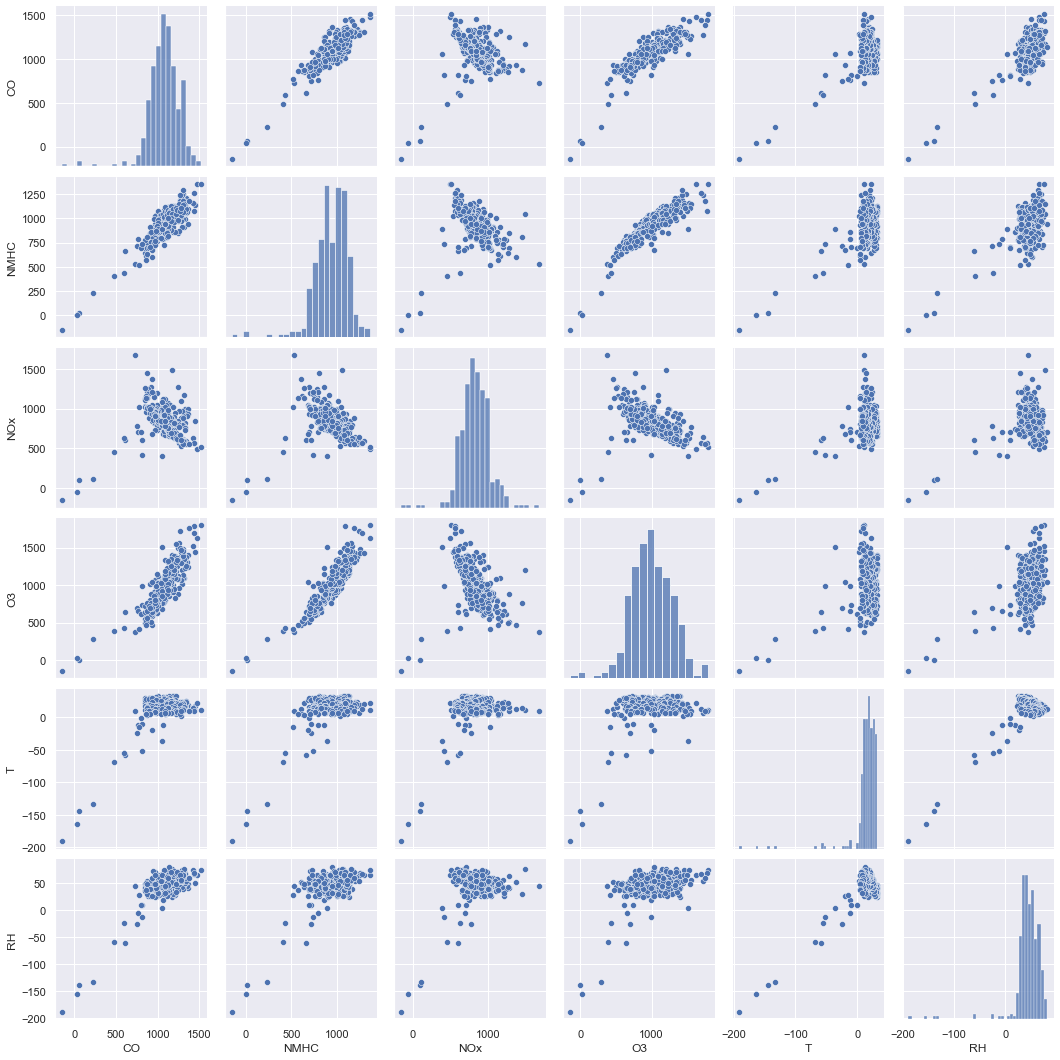

In [159]:
sns.pairplot(df_pivot)

We see that before we cleaned the data, there were many outliers, which do not follow the trend of the data.

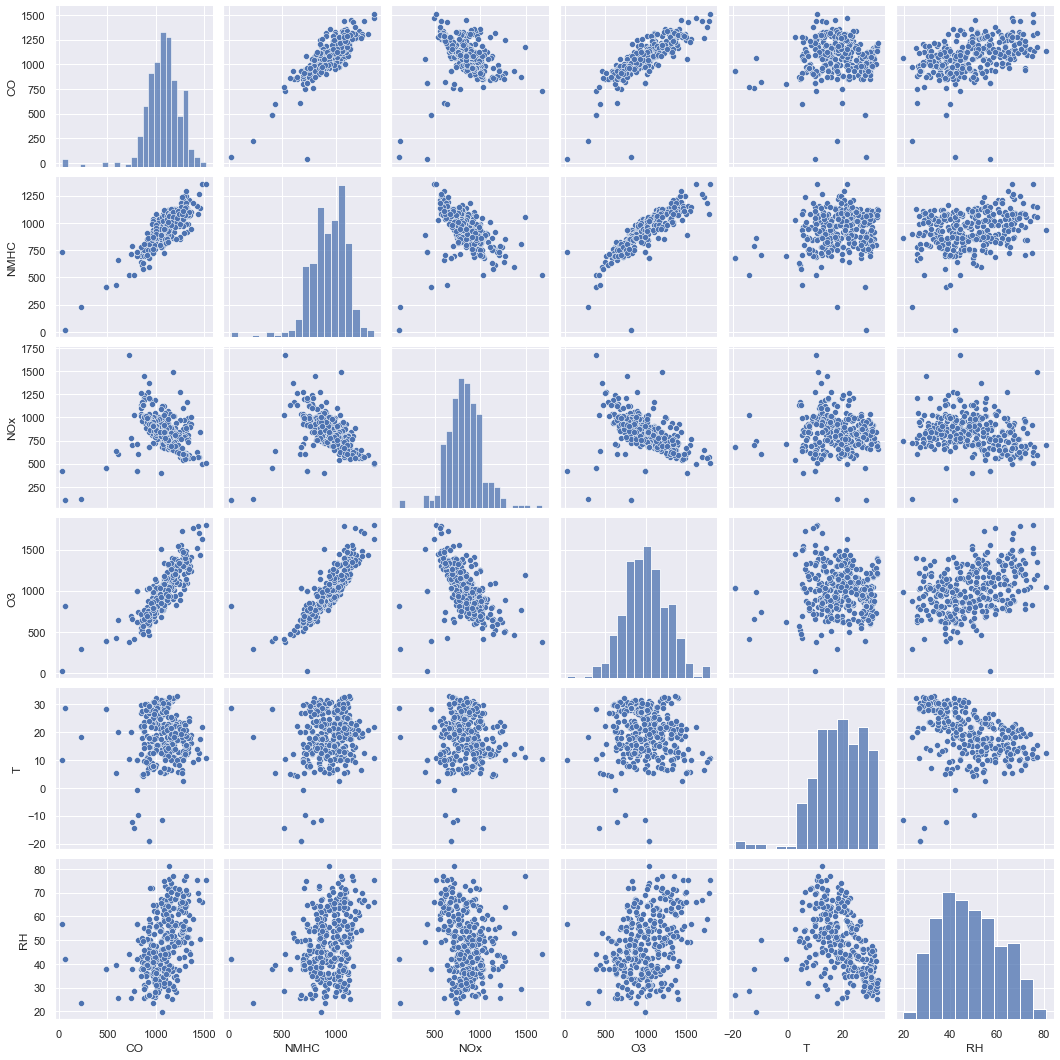

In [160]:
sns.pairplot(df_basic_clean)

To avoid recording spurious correlation (false correlation due to within-series dependence), we will instead calculate correlation based off the percentage change (the differenced data).

To calculate correlation, we use Pearson's correlation coefficient.

<AxesSubplot:xlabel='Gas', ylabel='Gas'>

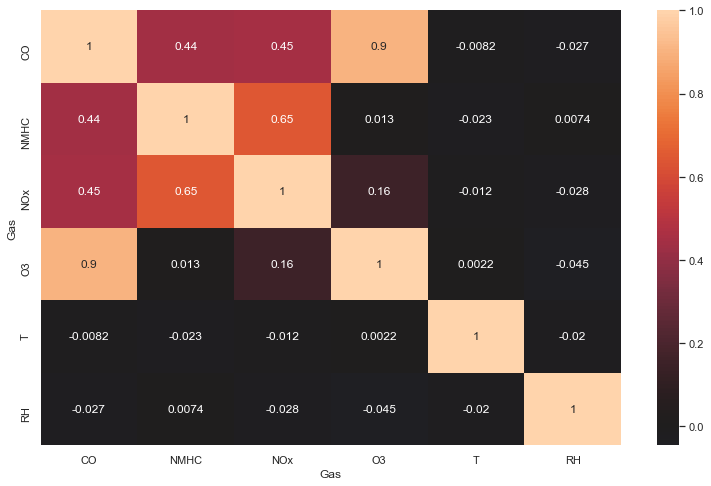

In [161]:
sns.heatmap(df_basic_clean.pct_change().corr(), annot=True, center=0)

- We observe that the change in CO levels is highly correlated with the change in Ozone (r=0.9) and NMHC (r=0.44) levels 

### Time Series

#### What can be said about the trend and seasonality of the data?

To have a clearer understanding of our data, we want to decompose the time series into it's components, which are: the Seasonal Component ($S_t$), the Trend-Cycle component ($T_t$), and the remainder components ($R_t$)

There are two ways which we can decompose our data, additively ($y_t = S_t + T_t + R_t$), or multiplicatively ($y_t = S_t \times T_t \times R_t$). Given that for most our our time series data (except that of Relative Humidity), the variance does not change as the mean changes, an additive model for decomposition makes the most sense. 

To decompose the data, we will use STL decomposition, due to it's advantages over classical decomposition methods. (it allows for the seasonal component to change over time, and is robust to outliers, which is important given that we showed earlier that unusual observations exist in the data). 

##### Temperature (T)

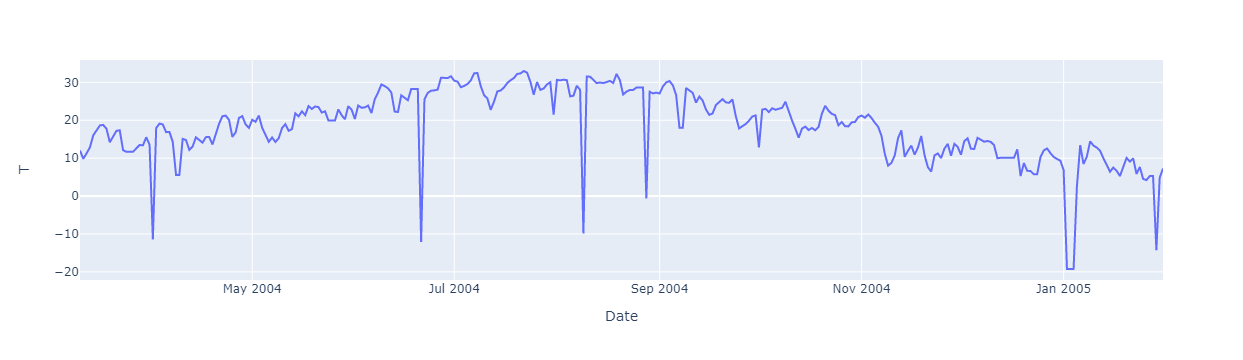

In [162]:
px.line(data_frame=df_basic_clean, y='T')

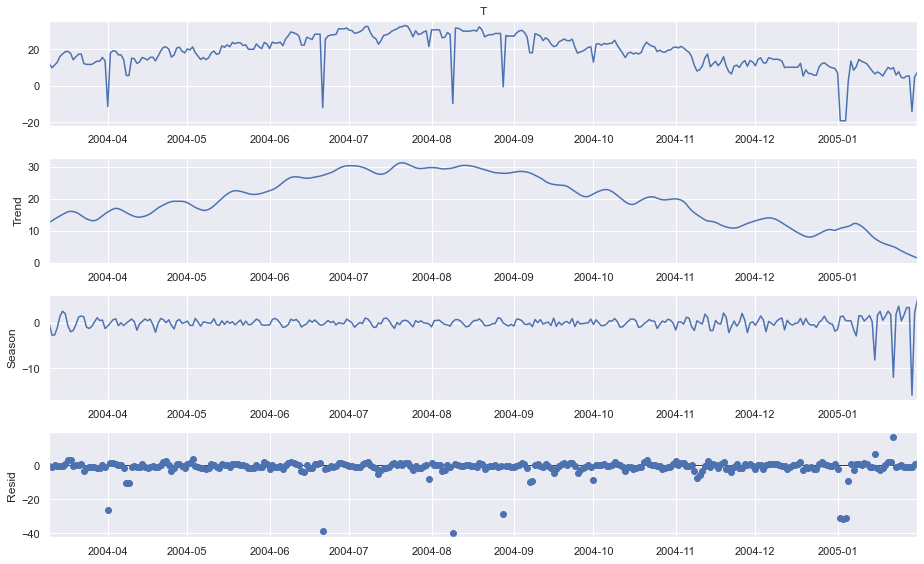

In [163]:
res = STL(df_basic_clean['T'], robust=True).fit()
res.plot()
plt.show()

- There is a upward non-linear trend in temperature from April to August, before the trend changes direction to become downwards. 
- The seasonality in the data does not appear to be very strong, and seems inconsistent.
- The temperature peaked between the months of June and September, where temperature was between 20 to 30 degrees celcius. The peak temperatures occured in July, where some days were above 30 degrees.
- The temperature is the lowest during the start of the year and near the end of the year, which are during the Winter season.
- The mean temperature does not remain constant through the year, but the variance appears to remain constant through the year.

##### Relative Humidity (RH)

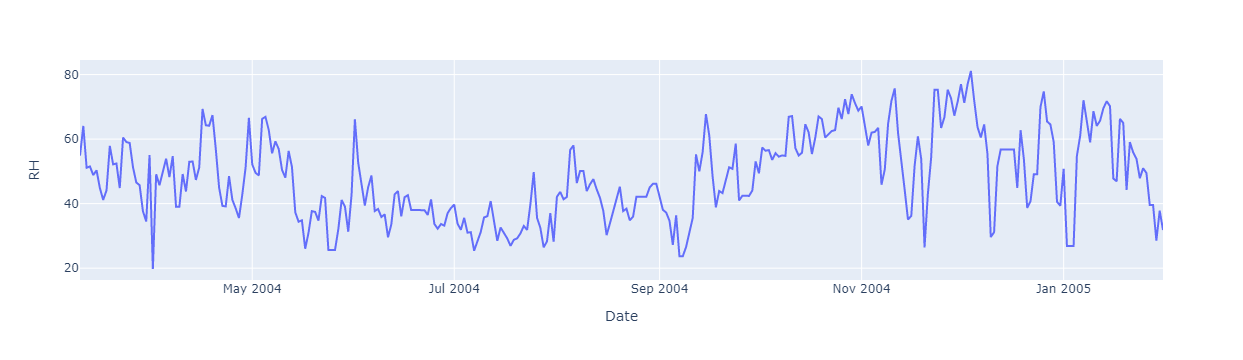

In [164]:
px.line(data_frame=df_basic_clean, y='RH')

We note that the variance of the relative humidity appears to increase when the relative humidity increases. This suggests a multiplicative decomposition of the data is appropriate. Since STL decomposition is only additive, we will use classical decomposition methods for this feature.

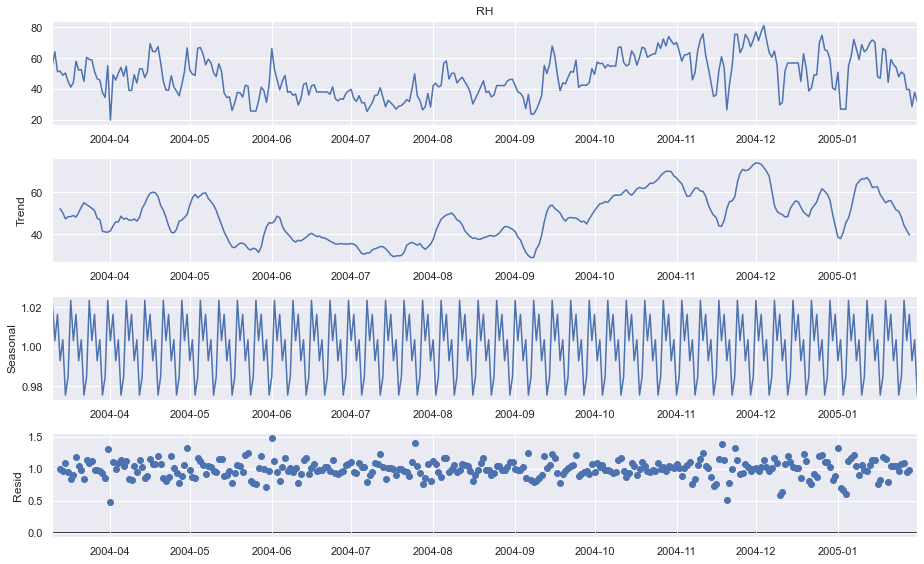

In [165]:
res = seasonal_decompose(df_basic_clean['RH'], 'multiplicative')
res.plot()
plt.show()

- There is a downward trend in relative humidity from April to August, before the trend changes direction to become downwards. The trend appears to be non-linear.
- It is clear that there is strong seasonality in the data, as even the trend appears to follow the seasonality after it is decomposed.
- The mean and variance of the relative humidity do not appear to be constant throughout the year, as the mean and variance of relative humidity appears to be lower during the months of June to September.
- This period of low humidity corresponds to a period of the highest temperatures of the year. This makes sense as **relative humidity is inversely proportional to temperature**
- Thus, the peak period of high relative humidity is also during the coldest parts of the year, during the end and the start of the year.

##### Carbon Monoxide (CO)

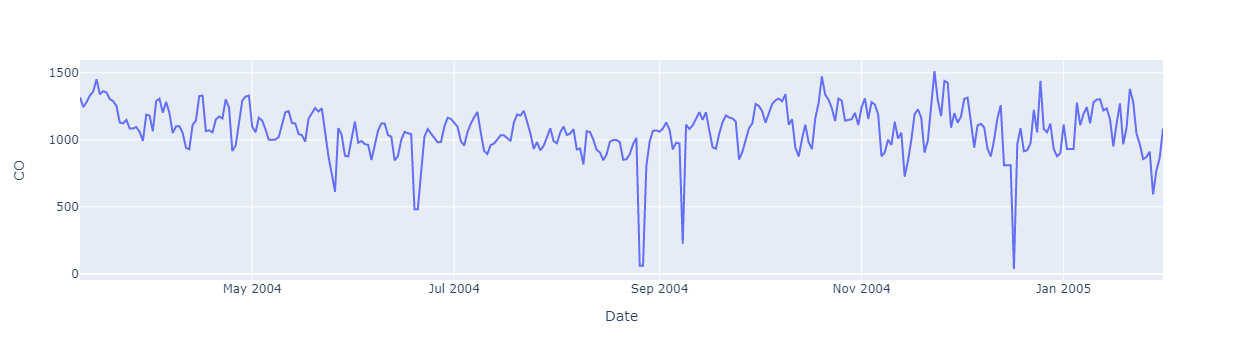

In [166]:
px.line(data_frame=df_basic_clean, y='CO')

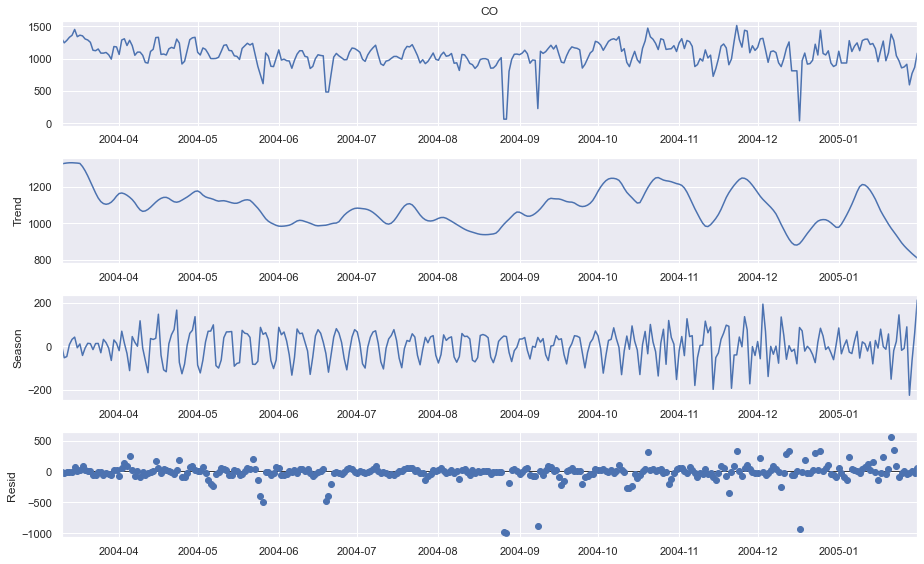

In [167]:
res = STL(df_basic_clean['CO'], robust=True).fit()
res.plot()
plt.show()

- The concentration of CO has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005 (but the trend becomes weaker nearing the end of the year)
- There is a seasonality in the data, that appears to repeat every week, where the concentration rises and falls. This could correspond to increased edmissions during the weekdays compared to weekends.
- The concentration of Carbon Monoxide appears to have a constant mean and variance, suggesting that it is stationary.
- On Weekends, it seems that CO concentration is lower, but this requires further statistical testing to verify. This could potentially be due to human sources of CO like vehicle emissions being lower when people are not working, and thus commuting less. 

##### Non-methane Hydrocarbons (NMHC)

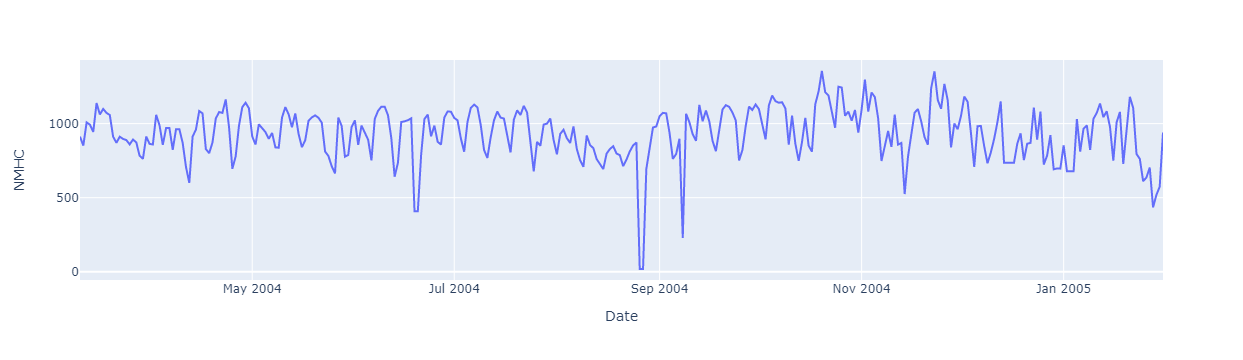

In [168]:
px.line(data_frame=df_basic_clean, y='NMHC')

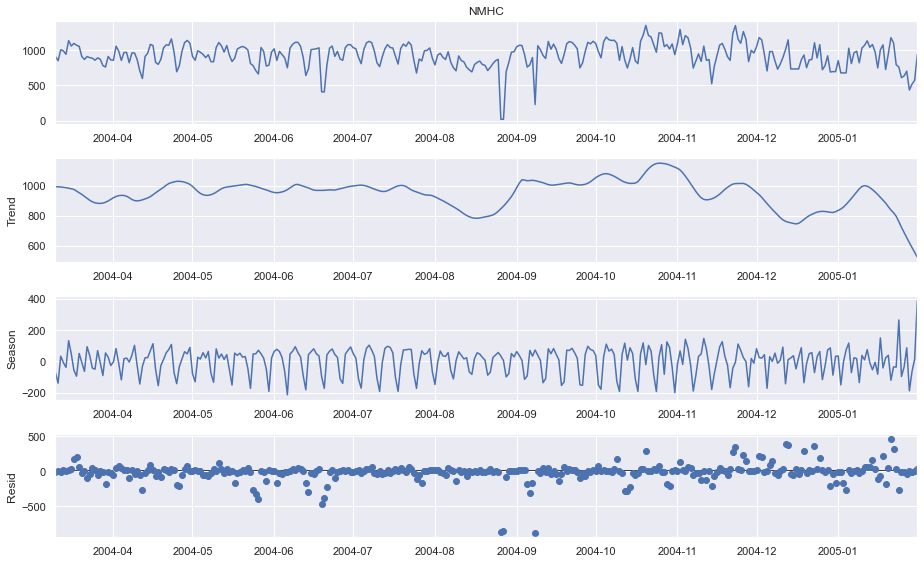

In [169]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- The trend for NMHC is very weak, and does not appear to change significantly
- The seasonality is much stronger, with there being a cycle that seemingly corresponds to each week.
- Similarily to that for CO, emissions of NMHC appear to be much lower during the weekends.
- One reason for this is that NMHC is also emitted via human sources like vehicle exhaust, chemical manufacturing and energy production, which might decrease during the weekend, when there is less human activity.

##### Nitrogen Oxides

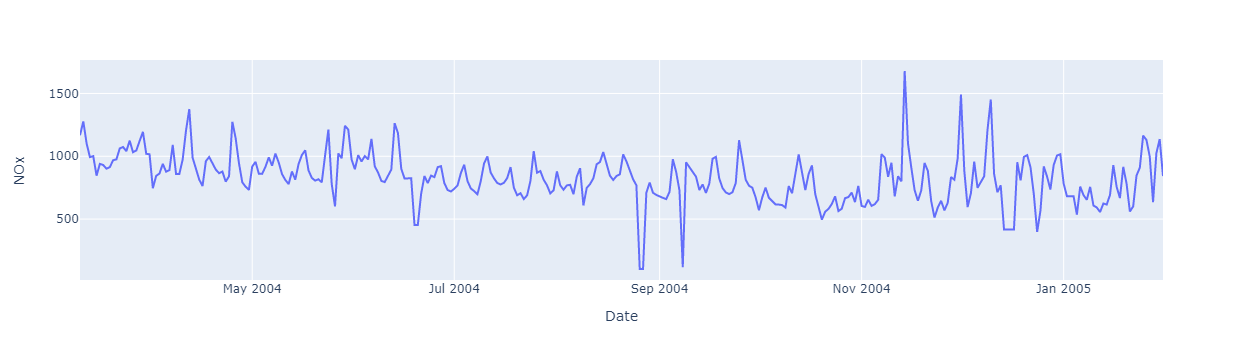

In [170]:
px.line(data_frame=df_basic_clean, y='NOx')

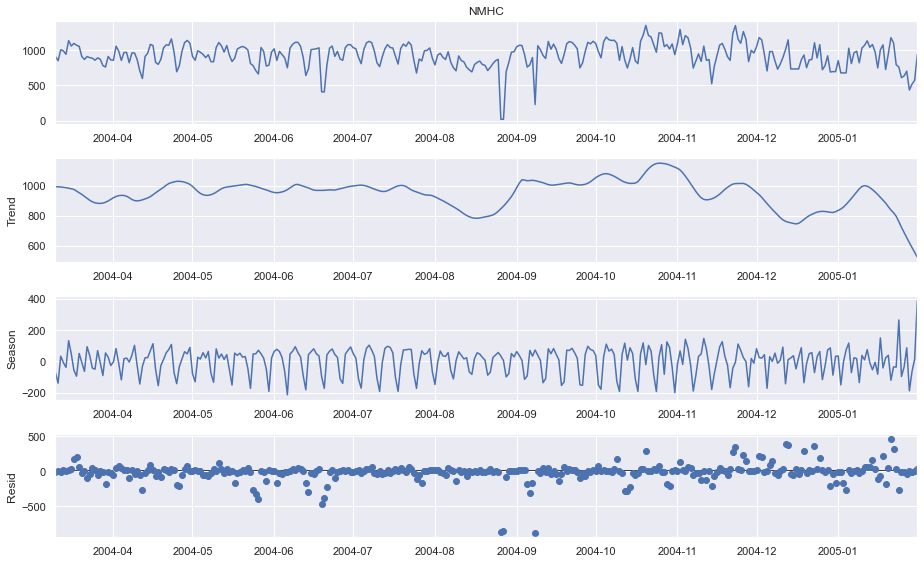

In [171]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- For NOx concentrations, the time series does not appear to be stationary, as the mean and variance vary slightly
- There appears to be a small downward trend in the data
- There is a non-linear downward trend between April 2004 to November 2004, before changing directions to an upward trend from December 2004 to January 2001. This suggests that emissions of Nitrogen Oxides have been decreasing over time.
- This is corroborated by referencing the emission trend of Nitrogen oxides in Italy, where there has been a sharp decrease in NOx emissions fromm 2000 to 2018. [Source](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- According to the European Environment Agency, this is due to the installation of catalysts to vehicles during this period as per new EU standards, resulting in lower NOx emissions from vehicles. (47% of the reduction in NOx emissions from 1990 and 2011 come from vehicle emissions)  [Source](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)

##### Ozone (O3)

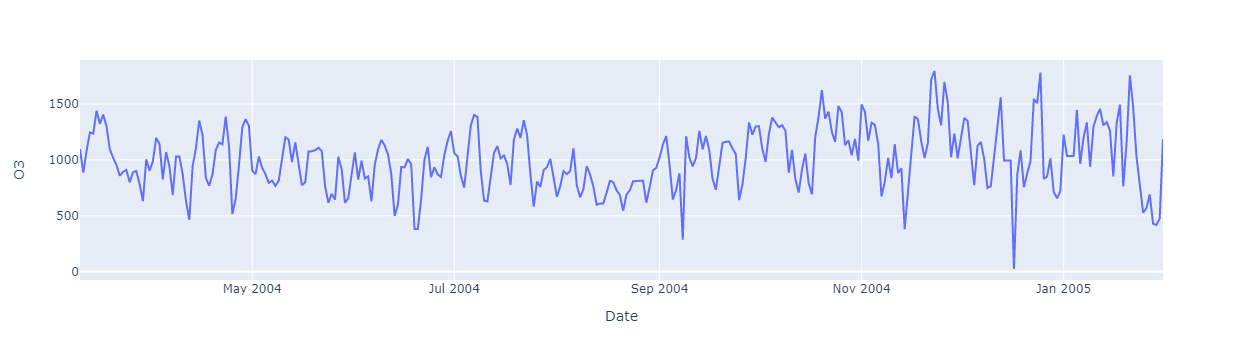

In [172]:
px.line(data_frame=df_basic_clean, y='O3')

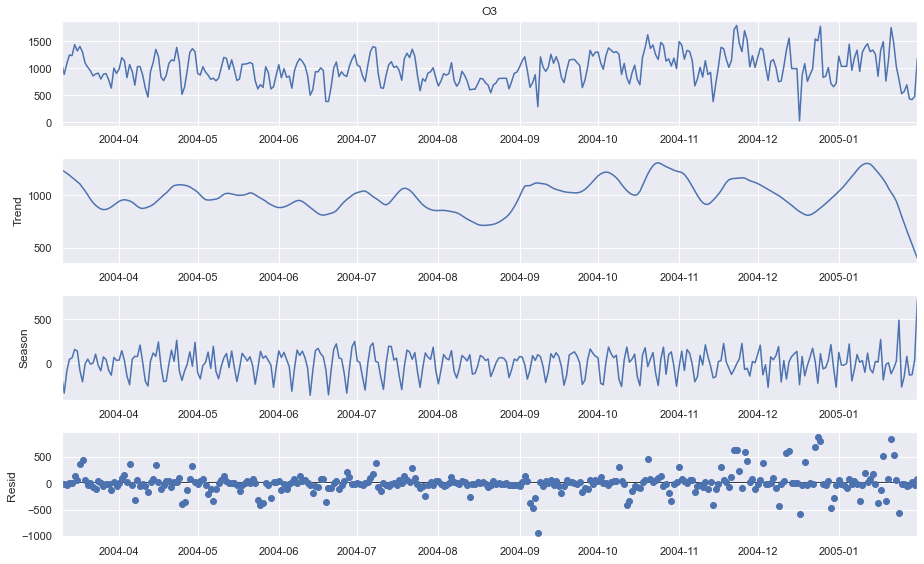

In [173]:
res = STL(df_basic_clean['O3'], robust=True).fit()
res.plot()
plt.show()

- The concentration of Ozone has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005.
- The time series appears to have a constant mean, but there is some variation in the variance, such as during the start of the year.
- According to the US Environmental Protection Agency,ground level ozone, is not emitted directly into the air, but is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.
- This may explain why the highest levels of Ozone are also the periods of time in which NOx levels are the highest (November to January)
- Strangely, this period is also very cold, and low temperatures should cause levels of Ozone to become lower. Hence it is likely that the increase in Ozone is due to the higher levels of NOx

##### Strength of Trend and Seasonality
It is useful for us to know how strong trend and seasonality are in our time series data, for later model selection and improvement.

[For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component.](https://otexts.com/fpp2/seasonal-strength.html) Therefore $Var(R_t)/Var(T_t+R_t)$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So the strength of trend is defined as
$$
F_t = \max (0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})
$$

Similarily, we define the strength of seasonality as
$$
F_s = \max (0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})
$$

In [174]:
trends, seasonality, residuals = [], [], []
for feature in df_basic_clean.columns:
    decomposition = STL(df_basic_clean[feature], robust=True).fit()
    trends.append(decomposition.trend)
    seasonality.append(decomposition.seasonal)
    residuals.append(decomposition.resid)

decompose_df = pd.DataFrame({
    "Var_Trend" : [trend.var() for trend in trends],
    "Var_Seasonality + Residual" : [(season + resid).var() for season, resid in zip(seasonality, residuals)],
    "Var_Trend + Residual" : [(trend + resid).var() for trend, resid in zip(trends, residuals)],
    "Var_Residuals":  [resid.var() for resid in residuals],
}, index = df_basic_clean.columns)
decompose_df['Trend Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Trend + Residual'])), axis = 1)
decompose_df['Seasonal Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Seasonality + Residual'])), axis = 1)

decompose_df

Var_Trend  Var_Seasonality + Residual  Var_Trend + Residual  \
Gas                                                                    
CO    10102.413936                23584.996228          35158.044584   
NMHC   9388.893215                23747.347272          26748.766489   
NOx   11085.555527                27198.962947          34876.283974   
O3    22094.398174                52172.255083          65342.591996   
T        56.985568                   27.794144             82.386004   
RH      118.949552                   66.441728            174.260273   

      Var_Residuals  Trend Strength  Seasonal Strength  
Gas                                                     
CO     21936.446830        0.376062           0.069898  
NMHC   18336.321271        0.314498           0.227858  
NOx    24251.980823        0.304628           0.108349  
O3     39294.674300        0.398636           0.246828  
T         27.205173        0.669784           0.021190  
RH        63.499944        0.635603           0.044276

- We see that out of all of the gases, Ozone has the strongest trend and Seasonality, whilst Carbon Monoxide has a strong trend but weak seasonality
- **No seasonal differencing** is recommended, as the strength of seasonality < 0.64 [Source: Forecasting Principles and Practices](https://otexts.com/fpp3/stationarity.html#unit-root-tests)

## Data Pre-processing
Now, we will proceed to process our data. This will involve transforming our data, and dealing with missing values and outliers.

In [333]:
test_df[pd.isnull(test_df).any(axis=1)]

T  RH   Gas
Date                    
2005-02-08 NaN NaN    CO
2005-02-09 NaN NaN    CO
2005-02-10 NaN NaN    CO
2005-02-11 NaN NaN    CO
2005-02-08 NaN NaN  NMHC
2005-02-09 NaN NaN  NMHC
2005-02-10 NaN NaN  NMHC
2005-02-11 NaN NaN  NMHC
2005-02-08 NaN NaN   NOx
2005-02-09 NaN NaN   NOx
2005-02-10 NaN NaN   NOx
2005-02-11 NaN NaN   NOx
2005-02-08 NaN NaN    O3
2005-02-09 NaN NaN    O3
2005-02-10 NaN NaN    O3
2005-02-11 NaN NaN    O3

In [336]:
test_df.head(12)

T         RH Gas
Date                               
2005-02-01  6.616667  51.734375  CO
2005-02-02  7.613194  43.930903  CO
2005-02-03  7.252083  50.966667  CO
2005-02-04  7.473611  50.166319  CO
2005-02-05  5.571875  46.604167  CO
2005-02-06  5.310417  39.594792  CO
2005-02-07  7.307986  35.396875  CO
2005-02-08       NaN        NaN  CO
2005-02-09       NaN        NaN  CO
2005-02-10       NaN        NaN  CO
2005-02-11       NaN        NaN  CO
2005-02-12  8.306944  59.144791  CO

In [353]:
def DataPreprocess(dataset, train = True, impute=True, remove_outliers=True, advanced_outlier_removal = False):
    dataset = dataset.copy(deep=True)
    missing_days = pd.isnull(dataset).any(axis=1)
    basic_outlier_rules = {
    "T" : (dataset['T'] < -20) | (dataset['T'] > 50),
    "RH" : (dataset['RH'] < 10) | (dataset['RH'] > 90)
}
    if remove_outliers:
        dataset.loc[basic_outlier_rules['T'], 'T'] = np.nan
        dataset.loc[basic_outlier_rules['RH'], 'RH'] = np.nan
        if train:
            additional_outlier_rules = {
            col : (dataset[col] < 0) for col in ('CO', 'NMHC', 'NOx', 'O3')
    } 
            for col in dataset.columns:
                if advanced_outlier_removal:
                    outliers = mark_outliers(dataset, col, k=3, window=7)
                    is_outlier = outliers
                    dataset.loc[is_outlier, col] = np.nan
                    print("No of Outliers (Advanced Rules) for", col, np.sum(is_outlier))
                else:
                    if col in additional_outlier_rules:
                        is_outlier = additional_outlier_rules[col]
                        dataset.loc[is_outlier, col] = np.nan
                        print("No of Outliers (Basic Filtering) for", col, np.sum(is_outlier))
                        dataset.loc[is_outlier, col] = np.nan
    if impute:
        dataset = dataset.interpolate(method='time', limit_direction='forward')
    if not train:
        return dataset, missing_days
    else:
        return dataset

            


In [367]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df_pivot = pd.pivot(df, values="Value", columns="Gas")
df_pivot[["T", "RH"]] = df[["T", "RH"]].groupby(df.index).mean()
train = DataPreprocess(df_pivot, train=True, remove_outliers=True, impute=True)
train

No of Outliers (Basic Filtering) for CO 1
No of Outliers (Basic Filtering) for NMHC 2
No of Outliers (Basic Filtering) for NOx 2
No of Outliers (Basic Filtering) for O3 2


Gas                  CO         NMHC          NOx           O3          T  \
Date                                                                        
2004-03-10  1316.500000   912.250000  1167.250000  1096.041667  12.020833   
2004-03-11  1244.062500   851.802083  1277.187500   885.031250   9.833333   
2004-03-12  1281.562500  1008.229167  1101.718750  1084.218750  11.292708   
2004-03-13  1330.555556   992.822917   993.159722  1245.781250  12.866319   
2004-03-14  1360.927083   943.854167  1001.104167  1234.177083  16.016667   
...                 ...          ...          ...          ...        ...   
2005-01-27   911.777778   703.312500   997.059028   691.475694   5.267708   
2005-01-28   592.864583   434.350694   635.225694   429.375000  -4.502604   
2005-01-29   769.625000   518.093750  1024.666667   418.072917 -14.272917   
2005-01-30   864.642361   573.684028  1136.718750   474.392361   4.848611   
2005-01-31  1084.500000   939.791667   842.177083  1184.166667   7.273958   

Gas                RH  
Date                   
2004-03-10  54.883334  
2004-03-11  64.069791  
2004-03-12  51.107292  
2004-03-13  51.530903  
2004-03-14  48.843750  
...               ...  
2005-01-27  39.614930  
2005-01-28  34.089236  
2005-01-29  28.563542  
2005-01-30  37.832986  
2005-01-31  31.809375  

[328 rows x 6 columns]

## Modelling

### Evaluation Methodology
To evaluate our models, we will make use of:
- Corrected AIC
- Time Series Cross Validated Root Mean Square Error

### Utility Functions

In [178]:
gases = ['CO', 'NMHC', 'NOx', 'O3']

In [179]:
def adf_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(series)
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    return test_statistic, pvalue, usedlag

In [180]:
def kpss_test(series, significance_level = 0.05):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
        test_statistic, pvalue, usedlag, *_ = kpss(series, regression="c", nlags="auto")
        print(f"P-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Reject H0. There is evidence that the time series is not stationary.")
        else:
            print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
        return test_statistic, pvalue, usedlag

In [181]:
def multi_step_predict(model, existing_data, start, end, model_params = {}, test_exog = None):
    """
    Does multi-step time series prediction, where the model is refitted for every new prediction.
    """
    forecasts = []
    data = existing_data
    for date in pd.date_range(start, end):
        cur_model = model(data, **model_params).fit()
        try:
            if test_exog is not None:
                current_exog = test_exog.loc[:date]
                forecast = cur_model.predict(start=date, exog=current_exog).values[0]
            else:
                forecast = cur_model.predict(start=date).values[0]
        except:
            forecast = cur_model.get_prediction(start=date).predicted_mean.values[0]
        # forecast = cur_model.forecast(steps=1)
        forecasts.append(forecast)
        data.append(pd.Series(forecast))
    return forecasts, cur_model

In [182]:
def eval_model(model, dataset, model_params = {}, cv = TimeSeriesSplit(5), refit=False):
    """
    Function to evaluate a given model. It makes an assumption that the dataset that is passed to it is already pre-processed, or that the model will process it.
    It will return:
    - the model used
    - cross-validated metrics
    - final metrics 
    """
    if 'order' in model_params:
        order = model_params['order']
    else:
        order = (0, 0, 0)
    if 'exog' in model_params:
        exog = model_params['exog']
    # Cross validate
    cv_metrics = defaultdict(list)
    for train_idx, test_idx in cv.split(dataset):
        if 'exog' in model_params:
            train_exog = exog.iloc[train_idx]
            test_exog = exog.iloc[test_idx]
            model_params['exog'] = train_exog
        else:
            train_exog = None
            test_exog = None
        train_fold = dataset.iloc[train_idx]
        test_fold = dataset.iloc[test_idx]
        try:
            res = model(train_fold, **model_params).fit()
        except:
            res = model(train_fold,  initialization='approximate_diffuse',**model_params).fit()
        try:
            cv_metrics['Corrected AIC'].append(res.aicc)
        except Exception as Error:
            print(Error)
        try:
            if train_exog is not None:
                train_preds = res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog)
            else:
                train_preds= res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1])
        except:
            train_preds = res.get_prediction(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog).predicted_mean
        # train_preds = res.forecast(len(train_idx - order[1]))
        rmse_train = np.sqrt(mean_squared_error(train_fold[0 + order[1]:], train_preds))
        cv_metrics['Train RMSE'].append(rmse_train)
        if refit:
            test_preds, _ = multi_step_predict(model, train_fold, test_fold.index[0], test_fold.index[-1], model_params=model_params, test_exog=test_exog)
        else:
            if train_exog is not None:
                test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1], exog=test_exog)
            else:
                test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1])
        rmse_test = np.sqrt(mean_squared_error(test_fold, test_preds))
        cv_metrics['Test RMSE'].append(rmse_test)
        cv_metrics['Difference in RMSE'].append(rmse_train - rmse_test)

    # Refit Model to Entire Training Set and Get Corrected AIC
    if 'exog' in model_params:
        model_params['exog'] = exog
    final_model = model(dataset, **model_params).fit()
    try:
        cv_metrics['Final AICc'] = [final_model.aicc] * cv.get_n_splits()
    except Exception as Error:
        print(Error)
    return final_model, cv_metrics

In [183]:
def parse_results(dataframe):
    cols = [pd.DataFrame(dataframe[col]) for col in dataframe.keys()]
    return pd.concat(cols, axis=1, keys=dataframe.keys())

In [184]:
def generate_file_name(text, extension = "pkl", location = "models", date = False):
    cur_date = pd.to_datetime("now")
    if date:
        return f"{location}/{text}_{cur_date.year}-{cur_date.month}-{cur_date.day}-{cur_date.hour}-{cur_date.minute}-{cur_date.second}.{extension}"
    else:
        return f"{location}/{text}.{extension}"

In [185]:
def record_history(model_name, cv_metrics, gas, past_history = None, save_history = True):
    if past_history is None:
        if save_history is True and path.exists("history.csv"):
            past_history = pd.read_csv("history.csv", index_col=0)
        else:
            past_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Final AICc', 'Gas'])
    cur_result = pd.Series({
        "Model Name" : model_name,
        "Mean Test RMSE" : np.mean(cv_metrics['Test RMSE']),
        'Difference in RMSE' : np.mean(cv_metrics['Difference in RMSE']),
        "Final AICc" : np.mean(cv_metrics['Final AICc']),
        "Gas" : gas
    })
    history = past_history.append(cur_result, ignore_index=True)
    if save_history:
        history.to_csv("history.csv")
    return history

In [186]:
def ts_plot(data, lags=62):
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(15, 8))
    time_plot = fig.add_subplot(gs[0, :])
    time_plot.plot(data)
    time_plot.set_title("Time Plot")
    acf_plot = fig.add_subplot(gs[1, 0])
    plot_acf(data, ax = acf_plot, lags=lags)
    pacf_plot = fig.add_subplot(gs[1, 1])
    plot_pacf(data, ax = pacf_plot, lags=lags)

    return fig

### Models

#### Exponential Smoothing

In [187]:
Exp_Smoothing_Results = defaultdict(list)
file_names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning) # Silence warning about initialization of model in future versions
    for gas in tqdm(gases):
        final_model, cv_metrics = eval_model(ExponentialSmoothing, train[gas])
        Exp_Smoothing_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ExpSmoothingModel-{gas}", date=False, location="models/ExpSmoothing")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ExpSmoothingModel-{gas}", cv_metrics, gas)
results = parse_results(Exp_Smoothing_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.51it/s]


##### Model Analysis

In [188]:
results.T

count         mean           std          min  \
CO   Corrected AIC         5.0  1624.806310  8.710816e+02   544.802350   
     Train RMSE            5.0   125.912704  1.986140e+01   105.170521   
     Test RMSE             5.0   214.046608  6.174111e+01   153.326073   
     Difference in RMSE    5.0   -88.133904  6.362676e+01  -189.273743   
     Final AICc            5.0  3335.346233  0.000000e+00  3335.346233   
NMHC Corrected AIC         5.0  1650.076316  8.768561e+02   554.355223   
     Train RMSE            5.0   136.339552  1.741844e+01   114.198185   
     Test RMSE             5.0   184.115621  5.937760e+01   130.120761   
     Difference in RMSE    5.0   -47.776069  6.329830e+01  -157.664416   
     Final AICc            5.0  3315.245757  0.000000e+00  3315.245757   
NOx  Corrected AIC         5.0  1658.214051  8.759119e+02   568.887369   
     Train RMSE            5.0   141.611445  1.414760e+01   127.744422   
     Test RMSE             5.0   202.599322  5.871902e+01   123.412368   
     Difference in RMSE    5.0   -60.987877  6.252520e+01  -155.877226   
     Final AICc            5.0  3369.682556  0.000000e+00  3369.682556   
O3   Corrected AIC         5.0  1768.174673  9.145017e+02   622.693181   
     Train RMSE            5.0   202.141171  7.894115e+00   191.984586   
     Test RMSE             5.0   328.276812  6.653184e+01   221.262598   
     Difference in RMSE    5.0  -126.135641  6.864236e+01  -193.717719   
     Final AICc            5.0  3601.976835  5.084230e-13  3601.976835   

                                 25%          50%          75%          max  
CO   Corrected AIC       1080.485242  1562.486260  2197.787180  2738.470518  
     Train RMSE           109.233456   122.005826   146.270423   146.883294  
     Test RMSE            176.087097   183.174342   259.138330   298.507199  
     Difference in RMSE  -112.255036   -54.081271   -48.155552   -36.903919  
     Final AICc          3335.346233  3335.346233  3335.346233  3335.346233  
NMHC Corrected AIC       1100.880877  1610.567641  2215.629005  2768.948832  
     Train RMSE           126.255903   133.636140   152.323527   155.284003  
     Test RMSE            150.824682   173.399315   182.313027   283.920320  
     Difference in RMSE   -36.626497   -29.989500   -18.115312     3.515380  
     Final AICc          3315.245757  3315.245757  3315.245757  3315.245757  
NOx  Corrected AIC       1112.863801  1614.458927  2202.163052  2792.697104  
     Train RMSE           129.439361   140.979703   147.732364   162.161375  
     Test RMSE            177.354443   209.550344   219.057805   283.621648  
     Difference in RMSE   -71.325441   -47.915082   -47.388969    17.567335  
     Final AICc          3369.682556  3369.682556  3369.682556  3369.682556  
O3   Corrected AIC       1191.336314  1749.710257  2334.529776  2942.603838  
     Train RMSE           199.584110   200.124496   205.831058   213.181606  
     Test RMSE            310.788219   347.661349   375.969588   385.702306  
     Difference in RMSE  -162.787982  -147.536854  -111.204109   -15.431539  
     Final AICc          3601.976835  3601.976835  3601.976835  3601.976835

In [189]:
history

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
0    ExpSmoothingModel-CO      214.046608          -88.133904  3335.346233   
1  ExpSmoothingModel-NMHC      184.115621          -47.776069  3315.245757   
2   ExpSmoothingModel-NOx      202.599322          -60.987877  3369.682556   
3    ExpSmoothingModel-O3      328.276812         -126.135641  3601.976835   

    Gas  
0    CO  
1  NMHC  
2   NOx  
3    O3

- The Exponential Smoothing model for Ozone appears to perform the worse, with a cross-validated RMSE of 328

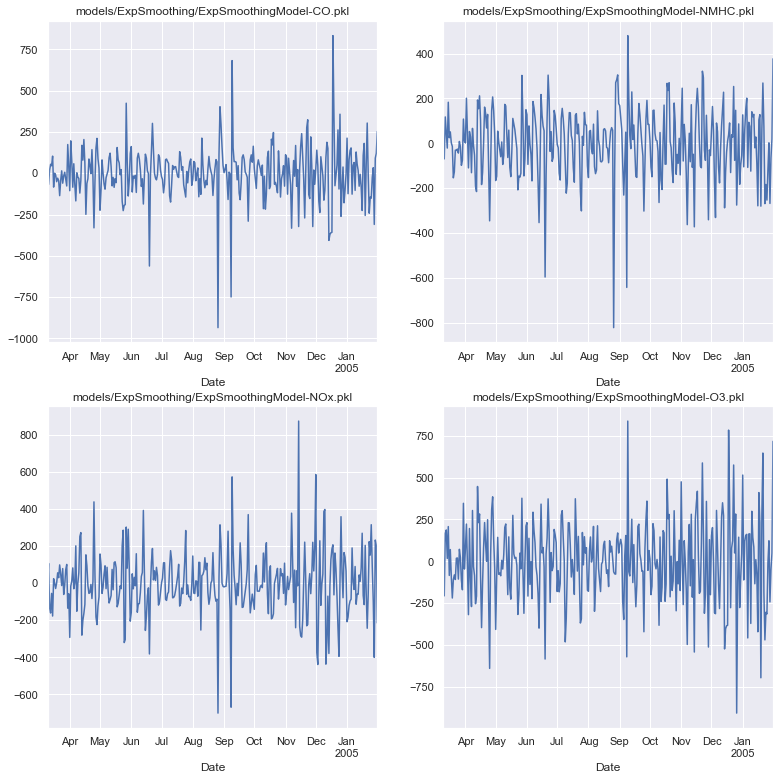

In [190]:
# Plot Residuals for Each Model
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
models = [(load(file), file) for file in file_names]
for model, subplot in zip(models, ax.ravel()):
    model[0].resid.plot(ax=subplot)
    subplot.set_title(model[1])

For the most part, the residuals appear to be homoskedastic.

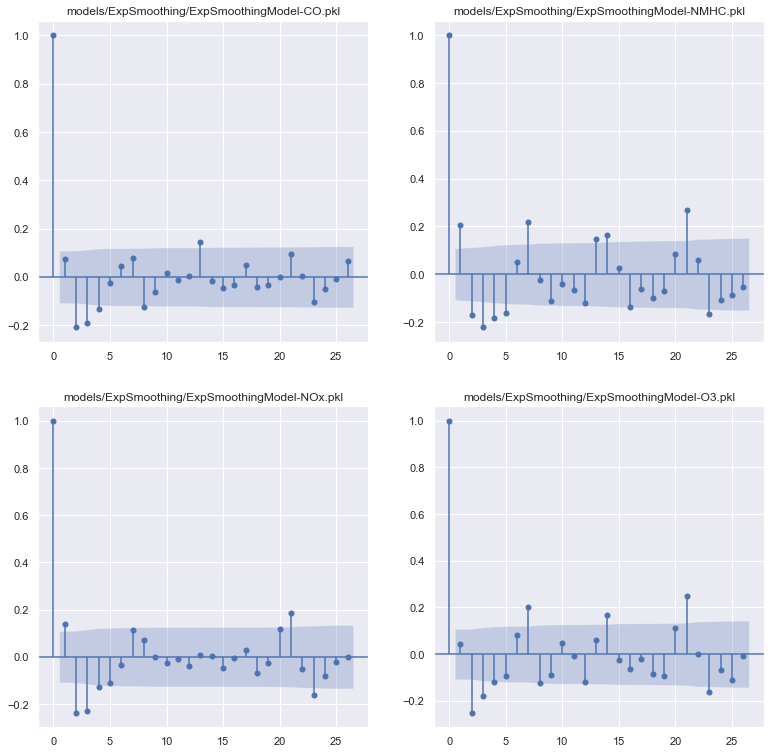

In [191]:
# Plot Autocorrelation of Residuals
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    plot_acf(model[0].resid, ax=subplot)
    subplot.set_title(model[1])

An ACF plot of the residuals suggests that our forecasts can be improved as the model still does not account for some information, which is left over in the residuals

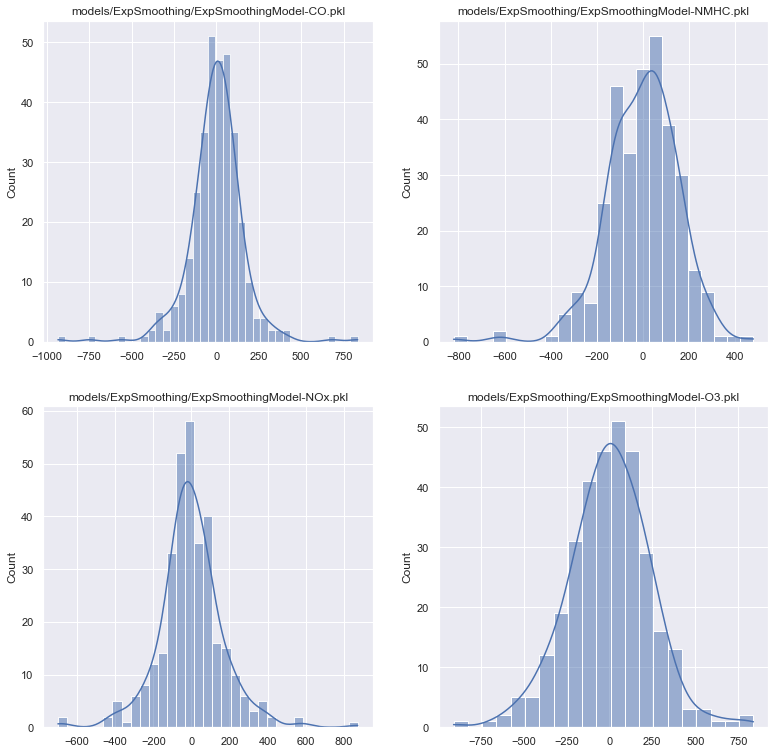

In [192]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    sns.histplot(model[0].resid, ax=subplot, kde=True)
    subplot.set_title(model[1])

The residuals appear to be normally distributed. While not essential, it is preferable for this to be the case.

#### ARIMA

##### Is the Data Stationary?

Before we can engage in modelling, we need to check if our data satisfies certain statistical assumptions that may be made by our models (ARIMA models). This will inform us if further pre-processing is needed. (e.g Differencing is required for our data).

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. 

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

[Source](https://otexts.com/fpp3/stationarity.html)

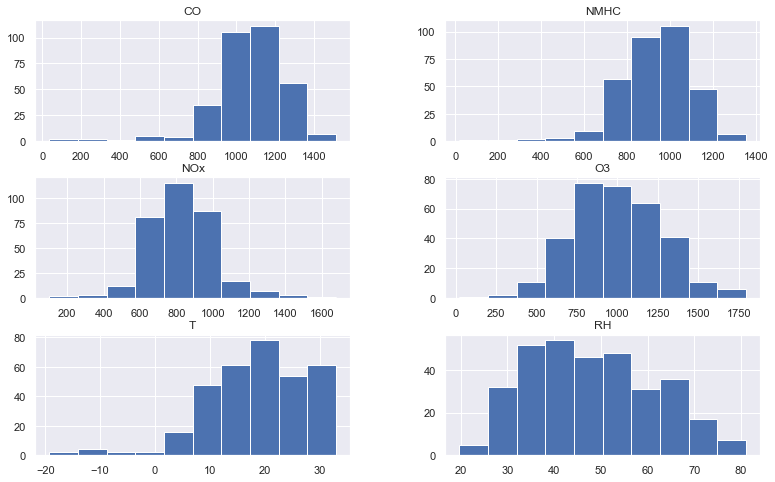

In [193]:
train.hist()
plt.show()

- On a first inspection, it appears that NOx is stationary. It is less clear if the rest are.

In [194]:
grp1 = train[:len(train) // 2]
grp2 = train[len(train) // 2:]

pd.concat([grp1.describe(), grp2.describe()], axis = 1, keys=["Grp1", "Grp2"]).T

count         mean         std         min         25%  \
     Gas                                                            
Grp1 CO    164.0  1071.233539  148.502711  481.753472  988.820313   
     NMHC  164.0   928.003525  131.248222  408.704861  845.799479   
     NOx   164.0   895.090024  147.592614  453.715278  796.906250   
     O3    164.0   938.729495  219.240231  382.131944  797.713542   
     T     164.0    21.844535    8.104707  -12.148958   16.668750   
     RH    164.0    42.783075   10.430817   19.742014   34.805469   
Grp2 CO    164.0  1070.028053  225.701653   36.281250  965.234375   
     NMHC  164.0   940.685086  201.612159   18.552083  819.289062   
     NOx   164.0   770.251524  203.675233  102.520833  644.192708   
     O3    164.0  1060.009527  316.176454   23.541667  829.388021   
     T     164.0    15.317867    8.511509  -19.247917   10.094531   
     RH    164.0    53.891071   13.337186   23.669792   43.834679   

                   50%          75%          max  
     Gas                                          
Grp1 CO    1059.015625  1158.091146  1452.010417  
     NMHC   930.397569  1034.760417  1163.041667  
     NOx    877.734375   975.135417  1376.031250  
     O3     931.322917  1087.466146  1439.041667  
     T       22.237847    28.783594    32.997917  
     RH      41.577952    49.856597    69.340625  
Grp2 CO    1110.880208  1205.656250  1513.208333  
     NMHC   963.611111  1084.477431  1355.104167  
     NOx    741.501736   884.520833  1678.687500  
     O3    1070.848958  1298.953993  1795.291667  
     T       14.696354    21.689323    30.365625  
     RH      54.857639    64.554427    81.104167

- The mean values for Grp 1 and 2 are similar for CO, NMHC, suggesting they are stationary

To tell more concretely if our data is stationary, we will conduct two tests, an Augmented Dickey Fuller Test, and a KPSS test.

###### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [195]:
for feature in train.columns:
    print(feature)
    adf_test(train[feature])

CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.032
Used Lag: 12
Reject H0. There is evidence that the time series is stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 6
Reject H0. There is evidence that the time series is stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 8
Reject H0. There is evidence that the time series is stationary.
T
Test f

- According to the ADF test, all of the gas time series are stationary
- We observe that temperature does not appear to be stationary, but relative humidity is

##### Selecting the Order of the ARIMA Model

When using an ARIMA model, it is necessary to specify the order of the model -> p, d, q 

p = order of the Auto Regressive part of the model
d = degree of differencing
q = order of the Moving Average part

It is usually not possible to tell, simply from a time plot, what values of p and q are appropriate for the data. However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for p and q.

If the data are from an ARIMA(p, d,0) or ARIMA(0, d, q) model, then the ACF and PACF plots can be helpful in determining the value of p or q. If p and q are both positive, then the plots do not help in finding suitable values of p and q.

The data may follow an ARIMA(p, d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

- the PACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag q in the ACF, but none beyond lag q.

[Source](https://otexts.com/fpp3/non-seasonal-arima.html)

Hence, we will use the ACF and PACF plot to estimate the models for each gas, to use as a baseline. We will then fit the identified model, and check that the model residuals are white noise.

###### Carbon Monoxide

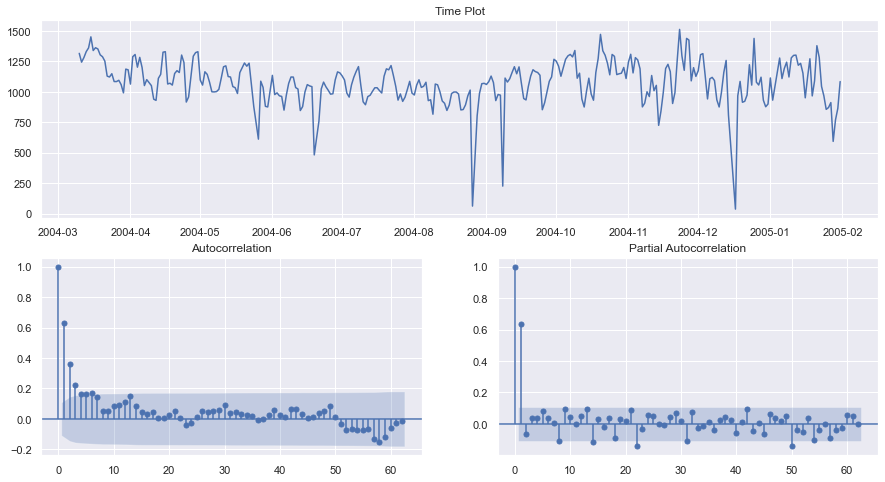

In [196]:
fig = ts_plot(train['CO'])

- Looking at the autocorrelation plot, it appear that the indicated model is an autoregressive model (as the ACF appears to be exponentially decaying)
- Looking then, at the PACF plot, there is a significant spike at lag 1, but none beyond that (there are some lags that are slightly above the confidence interval, but they do not appear to be significant)
- The data does not appear to have strong seasonality.
- This suggests an ARIMA(1, 0, 0) model

###### Non Metanic Hydrocarbons

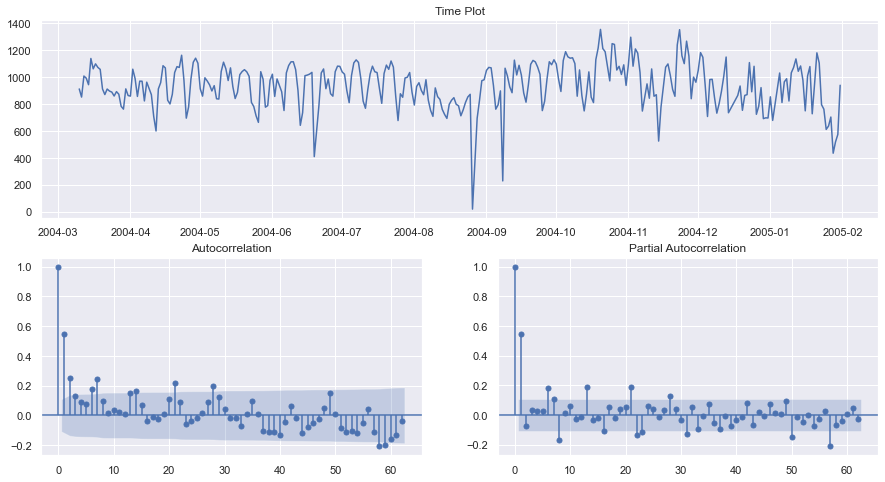

In [197]:
fig = ts_plot(train['NMHC'])

- Order identification is harder here
- Looking at the autocorrelation plot and the partial autocorrelation plot, both appear to tail off after lag 1. 
- This may indicate an ARMA(1,0,1) model
- We note that their appear to be spikes in both the ACF and PACF at Lags 7, 21, 28. This suggests there is some seasonality in the data, possibly a (3, 0, 3, 7) seasonal order
- Another view of the situation is that the ACF plot decays exponentially, while the PACF has a spike at lag one, suggesting an ARMA(1, 0, 0) model

###### Nitrogen Oxides

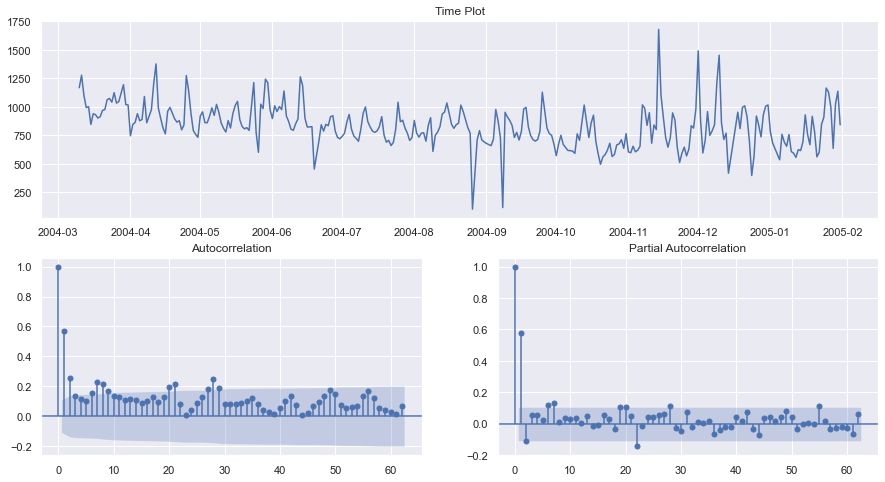

In [198]:
fig = ts_plot(train['NOx'])

- The spike in the PACF at Lag 1 suggests a ARIMA(1, 0, 0) model or a ARIMA(1,0,1) model (due to there being also a spike at the ACF plot)
- There appears to be some seasonal pattern in the ACF, with a spike at Lag 7, 21, and 28

###### Ozone

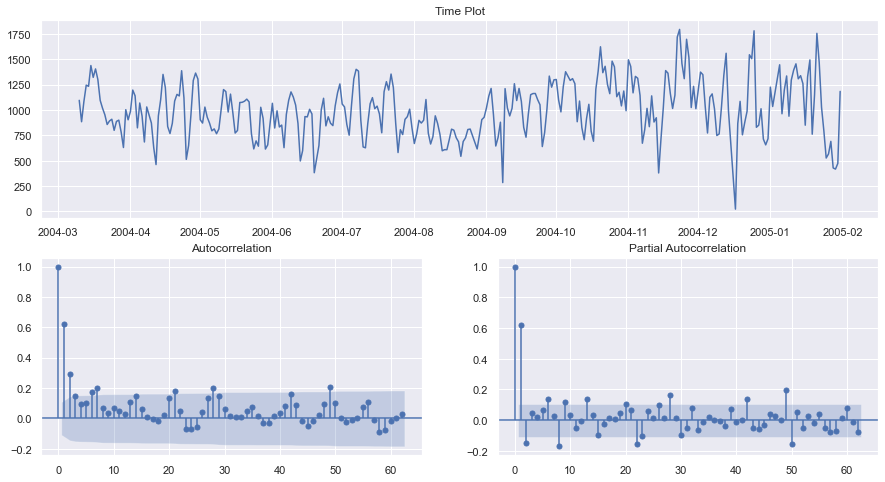

In [199]:
fig = ts_plot(train['O3'])

- There is a significant spike in the PACF at Lag 1, while the ACF appears to decay exponentially, suggesting an ARIMA(1, 0, 0) model
- There are seasonal spikes in the ACF at lag 7, 21, 28

In [200]:
ARIMA_Results = defaultdict(list)
file_names = []
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 1),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 0)
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(gases):
        order = orders[gas]
        final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order})
        ARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMA-{order}-{gas}", date=False, location="models/ARIMA")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ARIMA-{order}-{gas}", cv_metrics, gas)
results = parse_results(ARIMA_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.55it/s]


##### Model Analysis

In [201]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2073.390402  1099.713210   702.050691   
     Train RMSE            5.0   117.433400    17.946173    97.593868   
     Test RMSE             5.0   203.280773    48.675030   127.756060   
     Difference in RMSE    5.0   -85.847372    50.968367  -125.350817   
     Final AICc            5.0  4213.796890     0.000000  4213.796890   
NMHC Corrected AIC         5.0  2078.564350  1106.284279   697.633942   
     Train RMSE            5.0   116.803684    20.079086    91.412733   
     Test RMSE             5.0   177.202617    37.877661   128.391957   
     Difference in RMSE    5.0   -60.398933    34.936415  -113.358722   
     Final AICc            5.0  4188.780296     0.000000  4188.780296   
NOx  Corrected AIC         5.0  2100.516612  1106.076651   721.883797   
     Train RMSE            5.0   128.927281    14.184161   115.921209   
     Test RMSE             5.0   201.685957    39.566017   148.568795   
     Difference in RMSE    5.0   -72.758676    38.796118  -121.724548   
     Final AICc            5.0  4240.520784     0.000000  4240.520784   
O3   Corrected AIC         5.0  2206.920775  1141.518564   775.950534   
     Train RMSE            5.0   181.636575     7.847634   173.269637   
     Test RMSE             5.0   283.946615    78.702470   217.810042   
     Difference in RMSE    5.0  -102.310040    74.380685  -183.134657   
     Final AICc            5.0  4469.611308     0.000000  4469.611308   

                                 25%          50%          75%          max  
CO   Corrected AIC       1384.823703  2014.312908  2790.651926  3475.112783  
     Train RMSE           103.220049   114.499410   135.851326   136.002348  
     Test RMSE            186.580806   222.944685   224.150752   254.971560  
     Difference in RMSE  -120.930703  -118.969212   -50.729480   -13.256650  
     Final AICc          4213.796890  4213.796890  4213.796890  4213.796890  
NMHC Corrected AIC       1383.044848  2029.680410  2792.066682  3490.395868  
     Train RMSE           106.520796   111.746269   135.279113   139.059508  
     Test RMSE            148.232147   188.444869   201.064595   219.879518  
     Difference in RMSE   -65.785482   -56.819414   -49.385361   -16.645687  
     Final AICc          4188.780296  4188.780296  4188.780296  4188.780296  
NOx  Corrected AIC       1407.617565  2055.715585  2790.277621  3527.088491  
     Train RMSE           116.637614   126.511702   135.899105   149.666773  
     Test RMSE            172.959999   213.086923   235.451906   238.362162  
     Difference in RMSE   -99.552800   -63.420150   -57.038790   -22.057093  
     Final AICc          4240.520784  4240.520784  4240.520784  4240.520784  
O3   Corrected AIC       1485.118634  2188.796313  2913.648114  3671.090279  
     Train RMSE           178.126295   179.221063   183.489646   194.076235  
     Test RMSE            225.649799   237.002104   362.060237   377.210891  
     Difference in RMSE  -182.839174   -63.732467   -47.523504   -34.320396  
     Final AICc          4469.611308  4469.611308  4469.611308  4469.611308

In [202]:
history.sort_values("Mean Test RMSE")

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
5    ARIMA-(1, 0, 1)-NMHC      177.202617          -60.398933  4188.780296   
1  ExpSmoothingModel-NMHC      184.115621          -47.776069  3315.245757   
6     ARIMA-(1, 0, 0)-NOx      201.685957          -72.758676  4240.520784   
2   ExpSmoothingModel-NOx      202.599322          -60.987877  3369.682556   
4      ARIMA-(1, 0, 0)-CO      203.280773          -85.847372  4213.796890   
0    ExpSmoothingModel-CO      214.046608          -88.133904  3335.346233   
7      ARIMA-(1, 0, 0)-O3      283.946615         -102.310040  4469.611308   
3    ExpSmoothingModel-O3      328.276812         -126.135641  3601.976835   

    Gas  
5  NMHC  
1  NMHC  
6   NOx  
2   NOx  
4    CO  
0    CO  
7    O3  
3    O3

In terms of RMSE, the ARIMA models all outperform the Exponential Smoothing Models.

In [203]:
%%capture 
# ^suppress output
models = [load(file) for file in file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


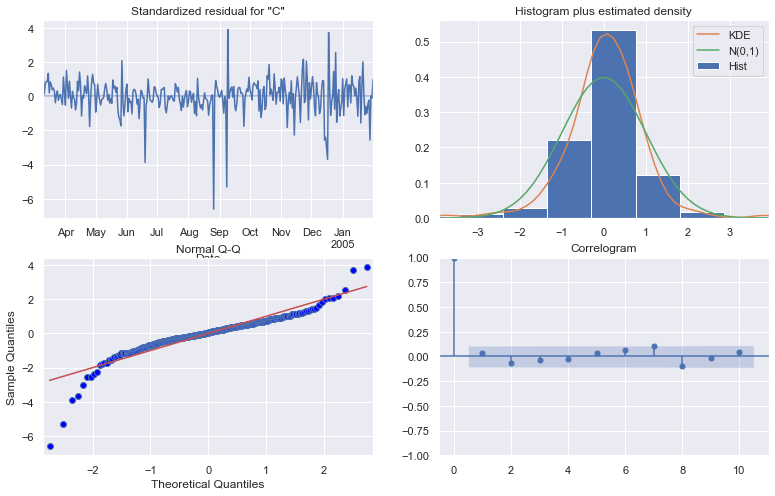

In [204]:
diagnostics[0]

- We observe from the Q-Q plot that the residuals are not normally distributed
- The correlogram does not show any significant correlation, except perhaps at Lag 7

In [205]:
models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2103.861
Date:                Thu, 12 Aug 2021   AIC                           4213.723
Time:                        19:03:21   BIC                           4225.102
Sample:                    03-10-2004   HQIC                          4218.263
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.6310     26.874     39.838      0.000    1017.958    1123.304
ar.L1          0.6317      0.025     25.173      0.000       0.582       0.681
sigma2      2.174e+04    807.941     26.909      0.000    2.02e+04    2.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1316.51
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for CO are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.62, hence we would fail to reject the Null hypothesis of independently distributed residuals. Hence the residuals of this ARIMA model likely have no autocorrelation.

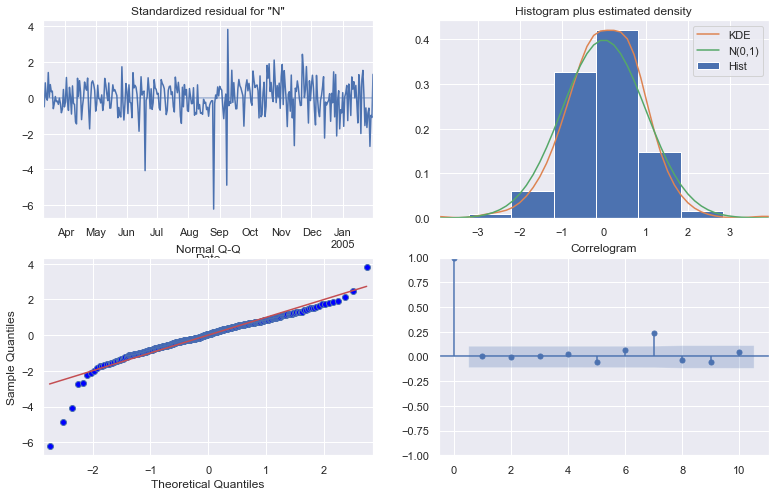

In [206]:
diagnostics[1]

- We observe that for NMHC:
    - Residuals are not normally distributed
    - There is significant correlation at Lag 7. This suggests that the ARIMA model fails to capture some sort of correlation that happens every week (i.e a seasonal pattern)

In [207]:
models[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NMHC   No. Observations:                  328
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2090.328
Date:                Thu, 12 Aug 2021   AIC                           4188.656
Time:                        19:03:21   BIC                           4203.829
Sample:                    03-10-2004   HQIC                          4194.710
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        934.3443     18.771     49.777      0.000     897.554     971.134
ar.L1          0.4456      0.111      4.007      0.000       0.228       0.664
ma.L1          0.1428      0.122      1.170      0.242      -0.096       0.382
sigma2      2.025e+04    918.167     22.058      0.000    1.85e+04    2.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               661.49
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The coefficient of the MA parameter does not appear to be significant.

In [208]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(ARIMA, train['NMHC'], model_params = {'order' : (1, 0, 0)})
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 176.62141191282205


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NMHC   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2091.259
Date:                Thu, 12 Aug 2021   AIC                           4188.517
Time:                        19:03:22   BIC                           4199.896
Sample:                    03-10-2004   HQIC                          4193.057
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        934.3443     19.717     47.388      0.000     895.700     972.988
ar.L1          0.5454      0.041     13.165      0.000       0.464       0.627
sigma2      2.024e+04    885.197     22.869      0.000    1.85e+04     2.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):               598.49
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -1.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We find that removing the MA term helps our model out.

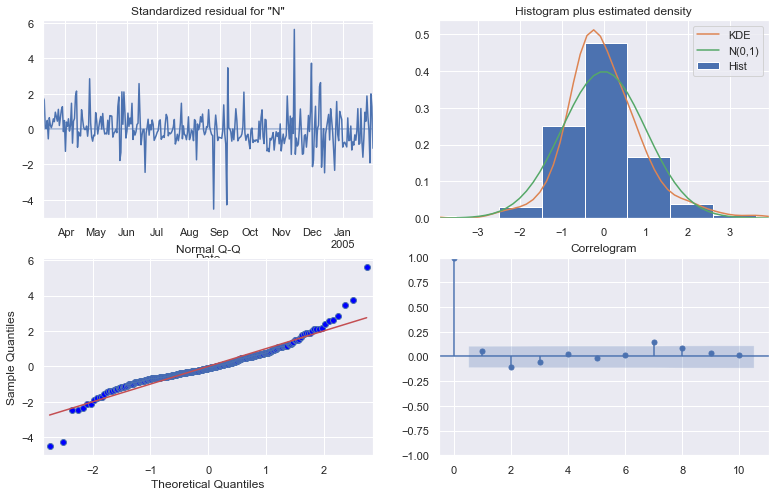

In [209]:
diagnostics[2]

- The residuals for NOx are certainly not normally distributed
- The correlogram shows a spike at Lag 7, suggesting that there is some seasonality in our data at weekly intervals.

In [210]:
models[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NOx   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2117.223
Date:                Thu, 12 Aug 2021   AIC                           4240.447
Time:                        19:03:22   BIC                           4251.826
Sample:                    03-10-2004   HQIC                          4244.987
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        832.6708     20.041     41.548      0.000     793.391     871.951
ar.L1          0.5763      0.035     16.285      0.000       0.507       0.646
sigma2      2.348e+04    970.359     24.202      0.000    2.16e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):               407.50
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for NOx are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.28, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

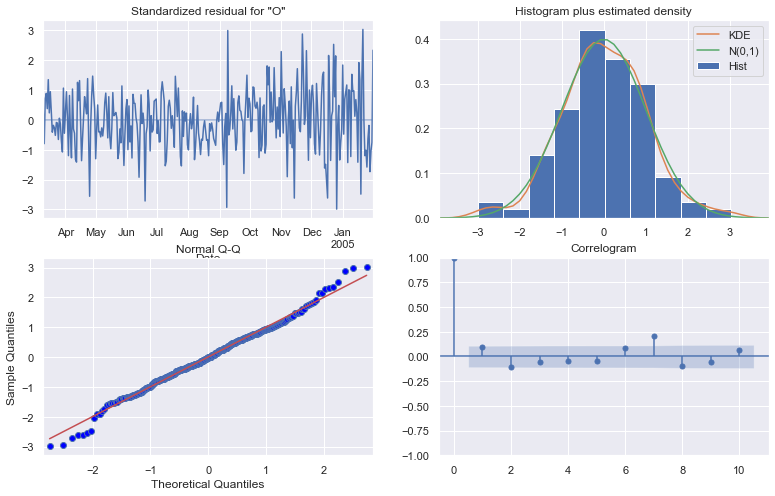

In [211]:
diagnostics[3]

- We observe that the residuals are mostly normally distributed
- There is one significant correlation at Lag 7, suggesting the ARIMA model does not account for seasonality that occurs on a weekly basis
- There is also a smaller correlation at Lag 2

In [212]:
models[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2231.769
Date:                Thu, 12 Aug 2021   AIC                           4469.537
Time:                        19:03:23   BIC                           4480.916
Sample:                    03-10-2004   HQIC                          4474.077
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        999.3695     31.654     31.572      0.000     937.329    1061.410
ar.L1          0.6189      0.036     17.044      0.000       0.548       0.690
sigma2      4.765e+04   3364.119     14.165      0.000    4.11e+04    5.42e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.93   Jarque-Bera (JB):                 3.95
Prob(Q):                              0.09   Prob(JB):                         0.14
Heteroskedasticity (H):               2.39   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for O3 are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.09, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

#### SARIMA

##### Identifying Seasonal Orders

The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.

The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1,12) model will show:

- a spike at lag 12 in the ACF but no other significant spikes;
- exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an ARIMA(0,0,0)(1,0,0,12) model will show:

- exponential decay in the seasonal lags of the ACF;
- a single significant spike at lag 12 in the PACF.
In considering the appropriate seasonal orders for a seasonal ARIMA model, restrict attention to the seasonal lags.

From our EDA, we discovered that we should not seasonally difference our data, as our data does not have strong seasonality ($F_s < 0.64$)

From our seasonal decomposition and analysis of the ADF and PACF, we know that the seasonal period is 7

In [213]:
seasonal_lags = [i*7 for i in range(10)]

###### Carbon Monoxide

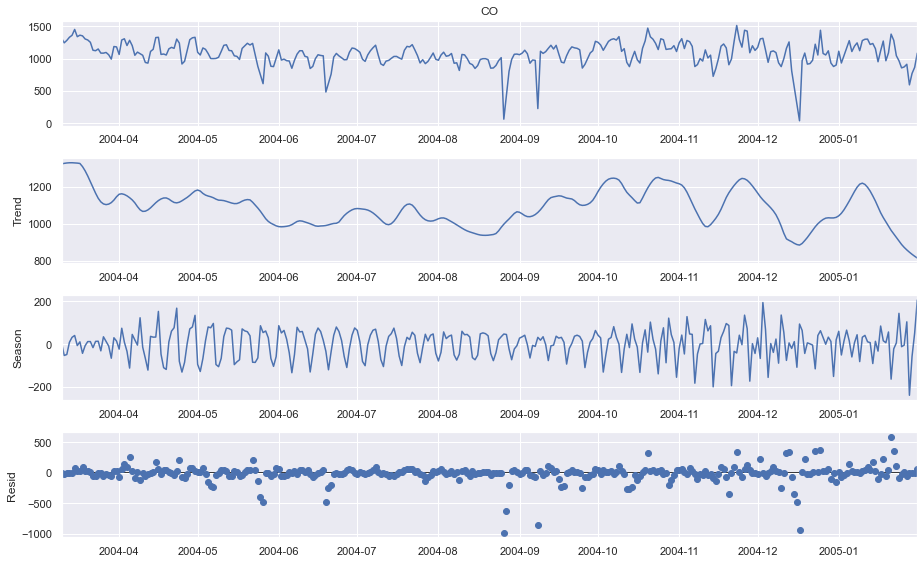

In [214]:
res = STL(train['CO'], robust=True).fit()
res.plot()
plt.show()

Looking at the decomposition of CO, there are four repeating seasons per month, suggesting m = 7.

In [215]:
decompose_df['Seasonal Strength']['CO']

0.06989822603268647

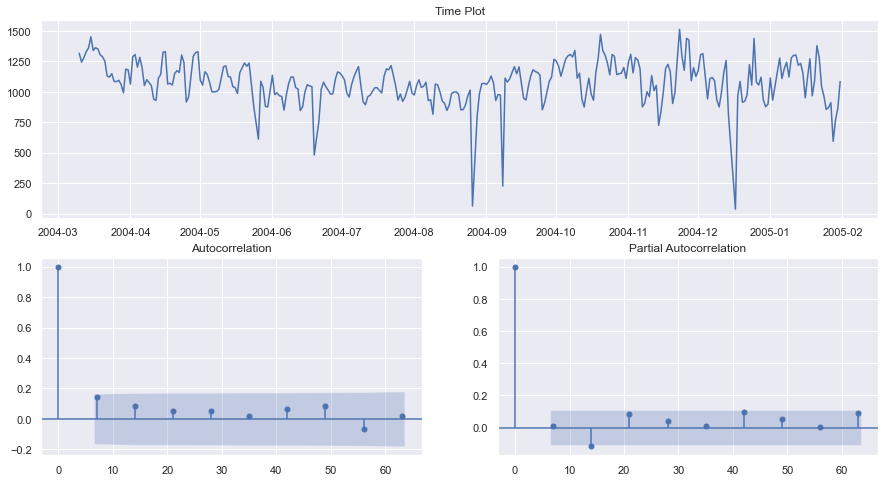

In [216]:
fig = ts_plot(train['CO'], seasonal_lags)

We observe that there do not appear to be any significant spikes at the seasonal lags. This suggests that we would be better served by an ARIMA model without any seasonality.

###### Non Metanic Hydrocarbons

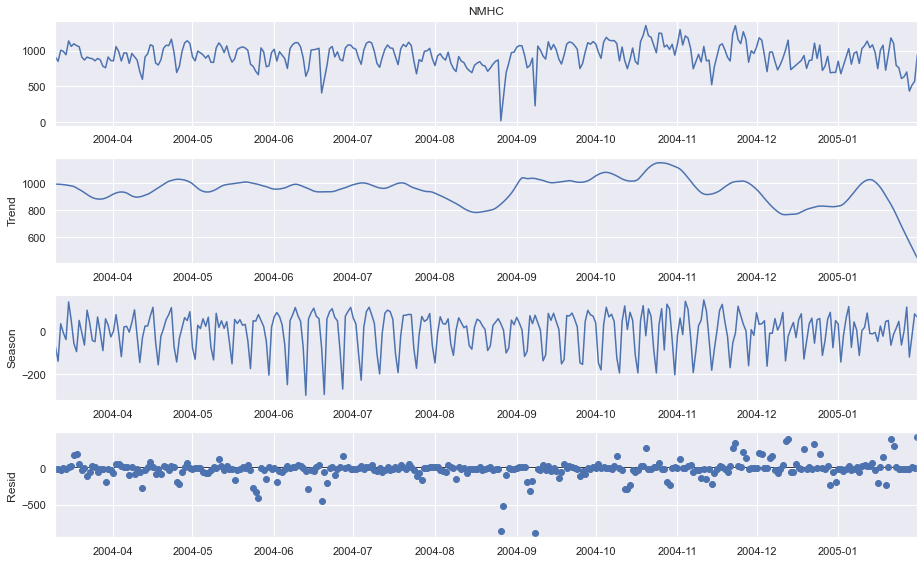

In [217]:
res = STL(train['NMHC'], robust=True).fit()
res.plot()
plt.show()

In [218]:
decompose_df['Seasonal Strength']['NMHC']

0.22785812404595274

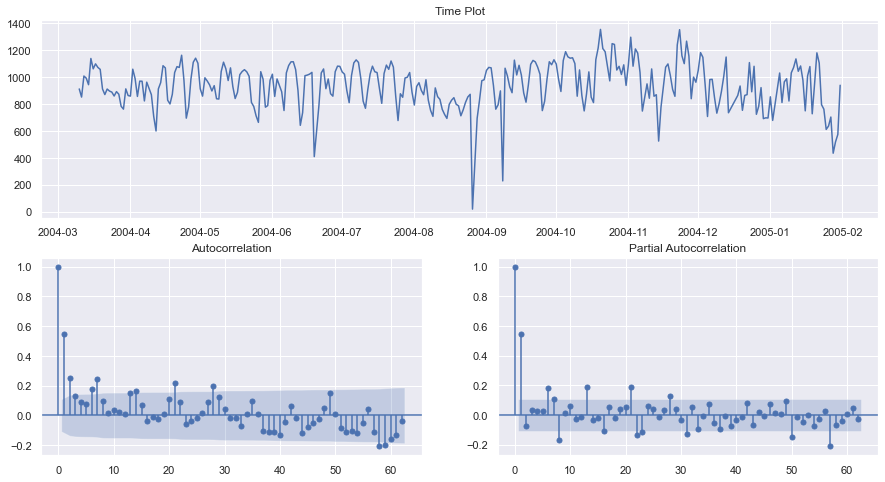

In [219]:
fig = ts_plot(train['NMHC'])

- This time series exhibits stronger seasonality. 
- We observe significant spikes in the ACF at lag 7, 14 and 21

- To be more conservative, we will assume a SMA(3) order instead of a (3, 0, 3, 7) seasonal order

###### Nitrogen Oxides

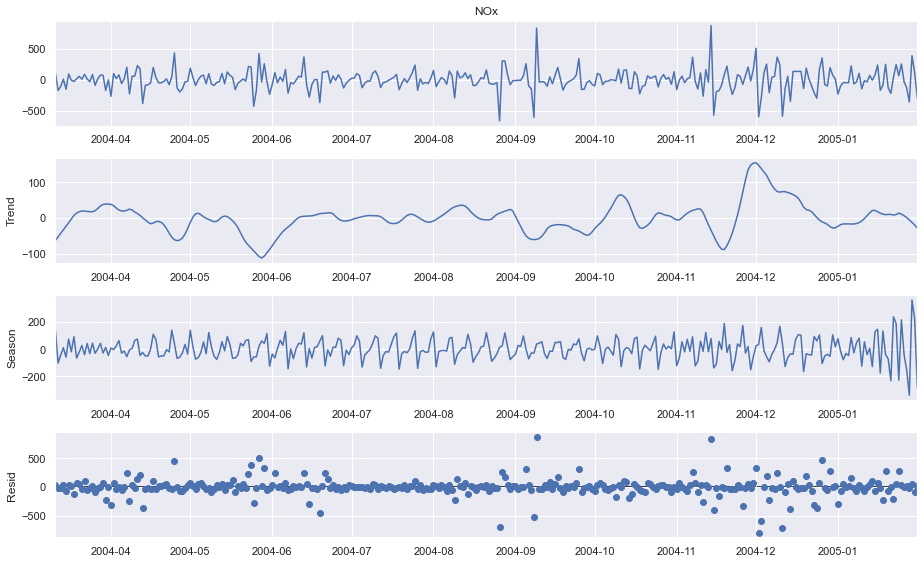

In [220]:
res = STL(diff(train['NOx']), robust=True).fit()
res.plot()
plt.show()

In [221]:
decompose_df['Seasonal Strength']['NOx']

0.10834906205123229

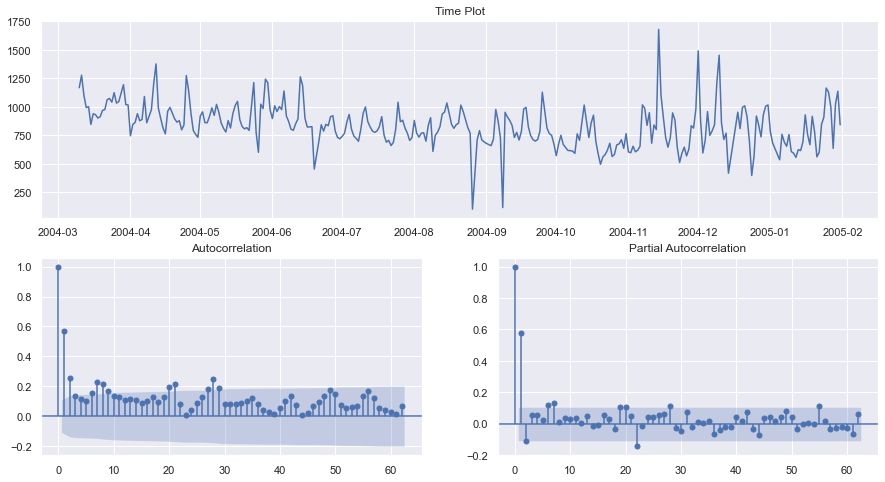

In [222]:
fig = ts_plot(train['NOx'])

- In the ACF plot, we see significant spikes at the first, third and fourth seasonal lags. 

###### Ozone

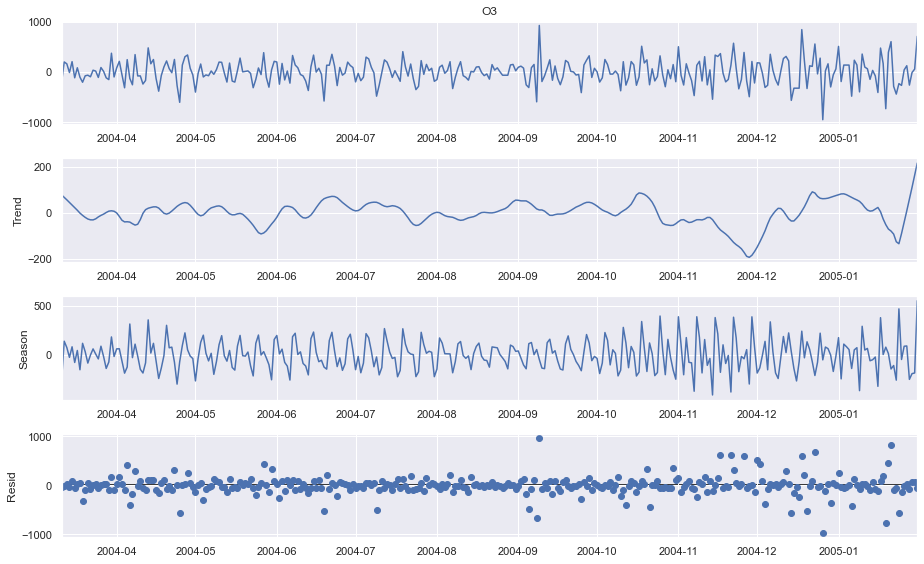

In [223]:
res = STL(diff(train['O3']), robust=True).fit()
res.plot()
plt.show()

In [224]:
decompose_df['Seasonal Strength']['O3']

0.24682814194582414

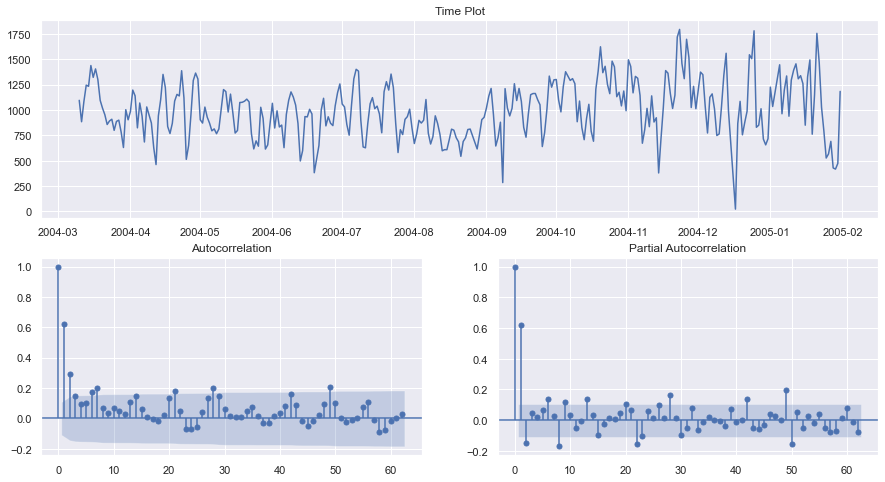

In [225]:
fig = ts_plot(train['O3'])

- From analysing the ACF plot, we see a Seasonal Spike at Lag 7, 21 and 28

In [226]:
seasonal_orders = {
    "NMHC" :  (0, 0, 3, 7),
    "NOx" :  (0, 0, (1, 3, 4), 7),
    "O3" :  (0, 0, (1, 3, 4), 7)
}
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 0)
}
SARIMA_Results = defaultdict(list)
file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order} | ({'seasonal_order' : seasonal_order} if seasonal_order is not None else {}))
        SARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMA-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMA")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMA-{order}-{seasonal_order}-{gas}", cv_metrics, gas)
results = parse_results(SARIMA_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.48s/it]


##### Model Analysis

In [227]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2104.845661  1117.920551   714.555821   
     Train RMSE            5.0   173.739830    18.850331   149.364671   
     Test RMSE             5.0   270.268912   126.188983    93.021233   
     Difference in RMSE    5.0   -96.529081   138.534622  -247.051085   
     Final AICc            5.0  4280.269100     0.000000  4280.269100   
NMHC Corrected AIC         5.0  2108.022701  1118.139057   715.769161   
     Train RMSE            5.0   150.387208    12.702621   129.428907   
     Test RMSE             5.0   489.107475    90.454133   337.918327   
     Difference in RMSE    5.0  -338.720267    93.828516  -442.232666   
     Final AICc            5.0  4244.135590     0.000000  4244.135590   
NOx  Corrected AIC         5.0  2133.991497  1115.145895   744.643989   
     Train RMSE            5.0   173.571426    17.396894   152.711940   
     Test RMSE             5.0   368.939796   135.394625   194.736219   
     Difference in RMSE    5.0  -195.368369   142.053333  -353.529610   
     Final AICc            5.0  4303.233031     0.000000  4303.233031   
O3   Corrected AIC         5.0  2225.987186  1143.951537   794.547682   
     Train RMSE            5.0   212.410941    20.535196   191.048606   
     Test RMSE             5.0   662.069605   163.247202   398.738690   
     Difference in RMSE    5.0  -449.658664   173.931110  -607.803470   
     Final AICc            5.0  4513.513255     0.000000  4513.513255   

                                 25%          50%          75%          max  
CO   Corrected AIC       1403.369332  2038.580803  2836.679259  3531.043090  
     Train RMSE           169.343947   173.767703   174.061824   202.161006  
     Test RMSE            185.682430   336.616693   339.608446   396.415756  
     Difference in RMSE  -167.272746  -165.840743    16.478576    81.040591  
     Final AICc          4280.269100  4280.269100  4280.269100  4280.269100  
NMHC Corrected AIC       1407.395908  2043.262194  2840.583785  3533.102458  
     Train RMSE           147.711043   155.756091   158.221261   160.818739  
     Test RMSE            487.362356   507.345670   541.249451   571.661573  
     Difference in RMSE  -385.493360  -349.124409  -326.543617  -190.207285  
     Final AICc          4244.135590  4244.135590  4244.135590  4244.135590  
NOx  Corrected AIC       1436.064655  2085.543916  2831.844462  3571.860463  
     Train RMSE           165.435017   173.946053   175.643608   200.120513  
     Test RMSE            269.211015   401.715105   451.560977   527.475663  
     Difference in RMSE  -286.125960  -226.071497  -116.499075     5.384295  
     Final AICc          4303.233031  4303.233031  4303.233031  4303.233031  
O3   Corrected AIC       1505.849218  2193.919454  2942.509109  3693.110468  
     Train RMSE           201.560481   209.577030   214.273381   245.595208  
     Test RMSE            615.110394   723.442732   774.204134   798.852076  
     Difference in RMSE  -572.643653  -513.865702  -369.515186  -184.465309  
     Final AICc          4513.513255  4513.513255  4513.513255  4513.513255

We note that the SARIMA CO model, with no seasonal order appears to overfit the data more than the ARIMA model for CO. We also observe that all the models appear to overfit our data heavily.

In [228]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  \
4                          ARIMA-(1, 0, 0)-CO      203.280773   
0                        ExpSmoothingModel-CO      214.046608   
8                    SARIMA-(1, 0, 0)-None-CO      270.268912   
5                        ARIMA-(1, 0, 1)-NMHC      177.202617   
1                      ExpSmoothingModel-NMHC      184.115621   
9          SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475   
6                         ARIMA-(1, 0, 0)-NOx      201.685957   
2                       ExpSmoothingModel-NOx      202.599322   
10  SARIMA-(1, 0, 0)-(0, 0, (1, 3, 4), 7)-NOx      368.939796   
7                          ARIMA-(1, 0, 0)-O3      283.946615   
3                        ExpSmoothingModel-O3      328.276812   
11   SARIMA-(1, 0, 0)-(0, 0, (1, 3, 4), 7)-O3      662.069605   

    Difference in RMSE   Final AICc   Gas  
4           -85.847372  4213.796890    CO  
0           -88.133904  3335.346233    CO  
8           -96.529081  4280.269100    CO  
5           -60.398933  4188.780296  NMHC  
1           -47.776069  3315.245757  NMHC  
9          -338.720267  4244.135590  NMHC  
6           -72.758676  4240.520784   NOx  
2           -60.987877  3369.682556   NOx  
10         -195.368369  4303.233031   NOx  
7          -102.310040  4469.611308    O3  
3          -126.135641  3601.976835    O3  
11         -449.658664  4513.513255    O3

In [229]:
%%capture 
# ^suppress output
models = [load(file) for file in file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


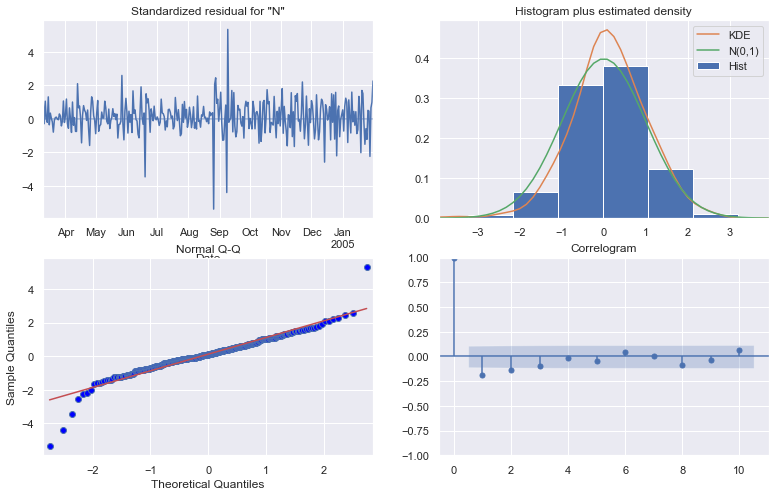

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                      NMHC   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2, 3], 7)   Log Likelihood               -2116.975
Date:                                   Thu, 12 Aug 2021   AIC                           4243.949
Time:                                           19:03:40   BIC                           4262.914
Sample:                                       03-10-2004   HQIC                          4251.516
                                            - 01-31-2005                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9723      0.015     63.635      0.000       0.942       1.002
ma.S.L7        0.2301      0.056      4.132      0.000       0.121       0.339
ma.S.L14       0.0260      0.044      0.585      0.558      -0.061       0.113
ma.S.L21       0.2104      0.065      3.225      0.001       0.082       0.338
sigma2      2.329e+04   1176.777     19.791      0.000     2.1e+04    2.56e+04
===================================================================================
Ljung-Box (L1) (Q):                  12.05   Jarque-Bera (JB):               453.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [230]:
display(diagnostics[1])
display(models[1].summary())

We observe that for NMHC, the MA term at Lag 14 is not significant, and should be removed.

In [231]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(SARIMAX, train['NMHC'], model_params = {'order' : (1, 0, 0), 'seasonal_order' : (0, 0, (1, 3), 7)})
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 430.25446283035933


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   NMHC   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 3], 7)   Log Likelihood               -2117.086
Date:                                Thu, 12 Aug 2021   AIC                           4242.172
Time:                                        19:03:42   BIC                           4257.344
Sample:                                    03-10-2004   HQIC                          4248.225
                                         - 01-31-2005                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9736      0.015     65.359      0.000       0.944       1.003
ma.S.L7        0.2243      0.047      4.752      0.000       0.132       0.317
ma.S.L21       0.2084      0.065      3.212      0.001       0.081       0.336
sigma2       2.33e+04   1094.378     21.291      0.000    2.12e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                  11.57   Jarque-Bera (JB):               422.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that reducing the number of SMA terms improves the model, but the model still heavily overfits the data.

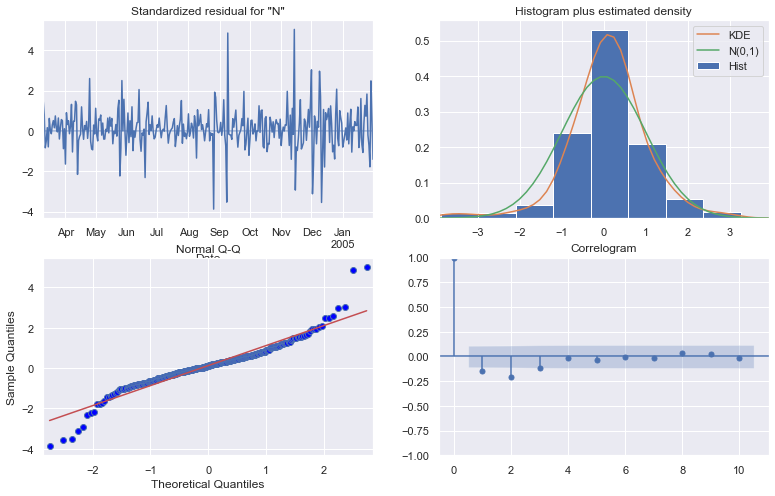

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                       NOx   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 3, 4], 7)   Log Likelihood               -2146.523
Date:                                   Thu, 12 Aug 2021   AIC                           4303.047
Time:                                           19:03:42   BIC                           4322.012
Sample:                                       03-10-2004   HQIC                          4310.613
                                            - 01-31-2005                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9649      0.013     71.496      0.000       0.938       0.991
ma.S.L7        0.1122      0.058      1.949      0.051      -0.001       0.225
ma.S.L21       0.1609      0.062      2.603      0.009       0.040       0.282
ma.S.L28       0.1337      0.064      2.092      0.036       0.008       0.259
sigma2      2.795e+04   1254.448     22.281      0.000    2.55e+04    3.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   6.83   Jarque-Bera (JB):               323.07
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [232]:
display(diagnostics[2])
display(models[2].summary())

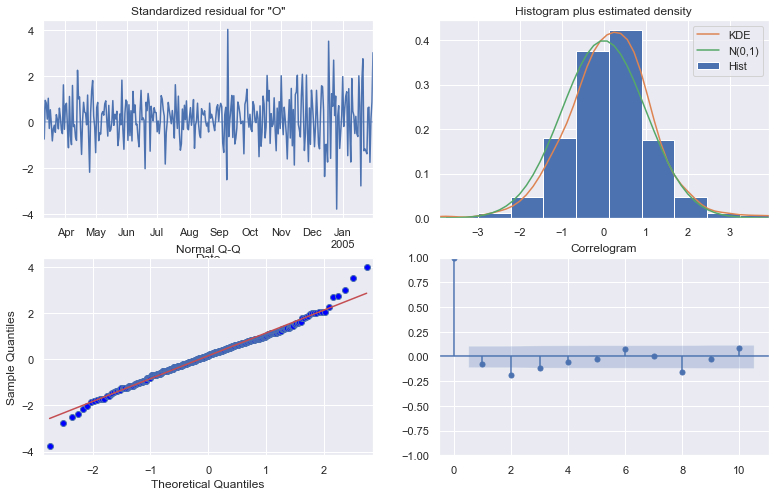

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                        O3   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 3, 4], 7)   Log Likelihood               -2251.663
Date:                                   Thu, 12 Aug 2021   AIC                           4513.327
Time:                                           19:03:43   BIC                           4532.292
Sample:                                       03-10-2004   HQIC                          4520.893
                                            - 01-31-2005                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9524      0.017     54.496      0.000       0.918       0.987
ma.S.L7        0.1704      0.058      2.927      0.003       0.056       0.285
ma.S.L21       0.1805      0.060      3.023      0.002       0.063       0.297
ma.S.L28       0.0811      0.062      1.307      0.191      -0.040       0.203
sigma2      5.312e+04   3300.180     16.097      0.000    4.67e+04    5.96e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.15   Jarque-Bera (JB):                26.87
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [233]:
display(diagnostics[3])
display(models[3].summary())

In [234]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(SARIMAX, train['O3'], model_params = {'order' : (1, 0, 0), 'seasonal_order' : (0, 0, (1, 3), 7)})
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 658.9459112903211


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                     O3   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 3], 7)   Log Likelihood               -2252.696
Date:                                Thu, 12 Aug 2021   AIC                           4513.392
Time:                                        19:03:45   BIC                           4528.564
Sample:                                    03-10-2004   HQIC                          4519.445
                                         - 01-31-2005                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9566      0.017     57.713      0.000       0.924       0.989
ma.S.L7        0.1531      0.054      2.846      0.004       0.048       0.259
ma.S.L21       0.1978      0.060      3.307      0.001       0.081       0.315
sigma2      5.344e+04   3325.663     16.069      0.000    4.69e+04       6e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):                26.84
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Improvement

#### Dynamic Regression Methods

##### ARIMAX

In [235]:
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 0)
}
ARIMAX_Results = defaultdict(list)
arimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order, 'exog' : exog})
        ARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMAX-{order}-{gas}", date=False, location="models/ARIMAX")
        arimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ARIMAX-{order}-{gas}", cv_metrics, gas)
results = parse_results(ARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


In [236]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2055.787041  1088.709875   699.003773   
     Train RMSE            5.0   110.169412    17.328364    91.616824   
     Test RMSE             5.0   193.274772    42.693334   144.608963   
     Difference in RMSE    5.0   -83.105360    52.202430  -145.234466   
     Final AICc            5.0  4173.575743     0.000000  4173.575743   
NMHC Corrected AIC         5.0  2077.578971  1098.621230   705.517374   
     Train RMSE            5.0   116.607705    17.034950    96.026742   
     Test RMSE             5.0   173.383985    31.652739   149.328488   
     Difference in RMSE    5.0   -56.776280    34.624106  -107.020707   
     Final AICc            5.0  4165.727418     0.000000  4165.727418   
NOx  Corrected AIC         5.0  2102.815024  1105.561018   725.440026   
     Train RMSE            5.0   128.040354    14.553551   114.788975   
     Test RMSE             5.0   200.519266    46.381325   141.373138   
     Difference in RMSE    5.0   -72.478912    46.599994  -132.037661   
     Final AICc            5.0  4237.772200     0.000000  4237.772200   
O3   Corrected AIC         5.0  2204.252811  1137.741955   777.987577   
     Train RMSE            5.0   177.871953     7.276782   170.382029   
     Test RMSE             5.0   297.895881    63.436251   238.481818   
     Difference in RMSE    5.0  -120.023928    58.700155  -192.281981   
     Final AICc            5.0  4456.111369     0.000000  4456.111369   

                                 25%          50%          75%          max  
CO   Corrected AIC       1373.281566  1993.049902  2774.166667  3439.433300  
     Train RMSE            96.061944   106.977310   126.515701   129.675281  
     Test RMSE            152.410440   204.048147   228.455021   236.851291  
     Difference in RMSE  -107.986203  -101.939321   -45.433130   -14.933682  
     Final AICc          4173.575743  4173.575743  4173.575743  4173.575743  
NMHC Corrected AIC       1384.871223  2033.209324  2786.261875  3478.035057  
     Train RMSE           107.011437   111.650664   132.887825   135.461858  
     Test RMSE            150.180111   152.028186   201.350997   214.032144  
     Difference in RMSE   -68.463172   -56.001444   -37.677824   -14.718253  
     Final AICc          4165.727418  4165.727418  4165.727418  4165.727418  
NOx  Corrected AIC       1410.576636  2055.705187  2793.598857  3528.754416  
     Train RMSE           115.075998   125.661575   135.664228   149.010995  
     Test RMSE            166.956468   204.264998   242.888068   247.113658  
     Difference in RMSE  -107.223841   -55.254002   -52.167493   -15.711563  
     Final AICc          4237.772200  4237.772200  4237.772200  4237.772200  
O3   Corrected AIC       1483.461745  2187.086204  2910.978029  3661.750501  
     Train RMSE           173.565293   176.526311   179.493815   189.392316  
     Test RMSE            251.419857   266.567247   364.202191   368.808291  
     Difference in RMSE  -174.809875   -87.073433   -77.854564   -68.099789  
     Final AICc          4456.111369  4456.111369  4456.111369  4456.111369

In [237]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  \
12                        ARIMAX-(1, 0, 0)-CO      193.274772   
4                          ARIMA-(1, 0, 0)-CO      203.280773   
0                        ExpSmoothingModel-CO      214.046608   
8                    SARIMA-(1, 0, 0)-None-CO      270.268912   
13                      ARIMAX-(1, 0, 0)-NMHC      173.383985   
5                        ARIMA-(1, 0, 1)-NMHC      177.202617   
1                      ExpSmoothingModel-NMHC      184.115621   
9          SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475   
14                       ARIMAX-(1, 0, 0)-NOx      200.519266   
6                         ARIMA-(1, 0, 0)-NOx      201.685957   
2                       ExpSmoothingModel-NOx      202.599322   
10  SARIMA-(1, 0, 0)-(0, 0, (1, 3, 4), 7)-NOx      368.939796   
7                          ARIMA-(1, 0, 0)-O3      283.946615   
15                        ARIMAX-(1, 0, 0)-O3      297.895881   
3                        ExpSmoothingModel-O3      328.276812   
11   SARIMA-(1, 0, 0)-(0, 0, (1, 3, 4), 7)-O3      662.069605   

    Difference in RMSE   Final AICc   Gas  
12          -83.105360  4173.575743    CO  
4           -85.847372  4213.796890    CO  
0           -88.133904  3335.346233    CO  
8           -96.529081  4280.269100    CO  
13          -56.776280  4165.727418  NMHC  
5           -60.398933  4188.780296  NMHC  
1           -47.776069  3315.245757  NMHC  
9          -338.720267  4244.135590  NMHC  
14          -72.478912  4237.772200   NOx  
6           -72.758676  4240.520784   NOx  
2           -60.987877  3369.682556   NOx  
10         -195.368369  4303.233031   NOx  
7          -102.310040  4469.611308    O3  
15         -120.023928  4456.111369    O3  
3          -126.135641  3601.976835    O3  
11         -449.658664  4513.513255    O3

It appears that using regression with ARIMA creates models which are actually more robust, as they overfit less. (the exception is for the Ozone model)

##### SARIMAX

In [238]:
seasonal_orders = {
    "NMHC" :  (0, 0, 3, 7),
    "NOx" :  (0, 0, (1, 3), 7),
    "O3" :  (0, 0, (1, 3), 7)
}
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 0)
}
SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog})
        SARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
        sarimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}", cv_metrics, gas)
    results = parse_results(SARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.55s/it]


In [239]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2106.689314  1133.952799   709.878977   
     Train RMSE            5.0   157.405488    17.730303   132.620733   
     Test RMSE             5.0   219.026721   124.617870    82.789339   
     Difference in RMSE    5.0   -61.621233   136.715836  -250.181671   
     Final AICc            5.0  4245.392792     0.000000  4245.392792   
NMHC Corrected AIC         5.0  2114.861578  1129.872873   712.905694   
     Train RMSE            5.0   146.784633    14.308424   122.845190   
     Test RMSE             5.0   328.315197   149.535597   183.178600   
     Difference in RMSE    5.0  -181.530564   163.669596  -437.772958   
     Final AICc            5.0  4232.495618     0.000000  4232.495618   
NOx  Corrected AIC         5.0  2137.985609  1117.929295   744.720717   
     Train RMSE            5.0   169.330600    14.090888   148.217691   
     Test RMSE             5.0   343.256611   120.468043   212.764075   
     Difference in RMSE    5.0  -173.926012   119.269265  -311.395178   
     Final AICc            5.0  4305.942688     0.000000  4305.942688   
O3   Corrected AIC         5.0  2235.092834  1144.174906   796.680672   
     Train RMSE            5.0   209.423490    23.395660   194.269383   
     Test RMSE             5.0   400.900504   175.792248   257.878335   
     Difference in RMSE    5.0  -191.477014   189.425319  -488.395518   
     Final AICc            5.0  4502.356742     0.000000  4502.356742   

                                 25%          50%          75%          max  
CO   Corrected AIC       1389.138112  2011.438797  2874.470431  3548.520252  
     Train RMSE           154.012937   155.162816   163.561641   181.669314  
     Test RMSE            156.914502   157.956326   314.671034   382.802404  
     Difference in RMSE  -159.508218     5.605315    24.754813    71.223598  
     Final AICc          4245.392792  4245.392792  4245.392792  4245.392792  
NMHC Corrected AIC       1412.358053  2026.544950  2868.083364  3554.415830  
     Train RMSE           144.671431   153.284986   154.565690   158.555867  
     Test RMSE            252.943806   256.600242   388.235189   560.618148  
     Difference in RMSE  -243.563758  -102.034552   -99.658821   -24.622733  
     Final AICc          4232.495618  4232.495618  4232.495618  4232.495618  
NOx  Corrected AIC       1440.910558  2087.813286  2835.046549  3581.436935  
     Train RMSE           164.101212   171.981958   177.086378   185.265759  
     Test RMSE            231.992183   353.492222   429.553020   488.481556  
     Difference in RMSE  -265.451809  -181.510264   -83.774491   -27.498316  
     Final AICc          4305.942688  4305.942688  4305.942688  4305.942688  
O3   Corrected AIC       1522.311194  2200.818028  2960.304099  3695.350176  
     Train RMSE           196.765536   200.787982   204.617162   250.677388  
     Test RMSE            266.549966   345.293842   452.115479   682.664901  
     Difference in RMSE  -251.327497  -148.528306   -53.261173   -15.872578  
     Final AICc          4502.356742  4502.356742  4502.356742  4502.356742

In [240]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  \
12                        ARIMAX-(1, 0, 0)-CO      193.274772   
4                          ARIMA-(1, 0, 0)-CO      203.280773   
0                        ExpSmoothingModel-CO      214.046608   
16                  SARIMAX-(1, 0, 0)-None-CO      219.026721   
8                    SARIMA-(1, 0, 0)-None-CO      270.268912   
13                      ARIMAX-(1, 0, 0)-NMHC      173.383985   
5                        ARIMA-(1, 0, 1)-NMHC      177.202617   
1                      ExpSmoothingModel-NMHC      184.115621   
17        SARIMAX-(1, 0, 0)-(0, 0, 3, 7)-NMHC      328.315197   
9          SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475   
14                       ARIMAX-(1, 0, 0)-NOx      200.519266   
6                         ARIMA-(1, 0, 0)-NOx      201.685957   
2                       ExpSmoothingModel-NOx      202.599322   
18    SARIMAX-(1, 0, 0)-(0, 0, (1, 3), 7)-NOx      343.256611   
10  SARIMA-(1, 0, 0)-(0, 0, (1, 3, 4), 7)-NOx      368.939796   
7                          ARIMA-(1, 0, 0)-O3      283.946615   
15                        ARIMAX-(1, 0, 0)-O3      297.895881   
3                        ExpSmoothingModel-O3      328.276812   
19     SARIMAX-(1, 0, 0)-(0, 0, (1, 3), 7)-O3      400.900504   
11   SARIMA-(1, 0, 0)-(0, 0, (1, 3, 4), 7)-O3      662.069605   

    Difference in RMSE   Final AICc   Gas  
12          -83.105360  4173.575743    CO  
4           -85.847372  4213.796890    CO  
0           -88.133904  3335.346233    CO  
16          -61.621233  4245.392792    CO  
8           -96.529081  4280.269100    CO  
13          -56.776280  4165.727418  NMHC  
5           -60.398933  4188.780296  NMHC  
1           -47.776069  3315.245757  NMHC  
17         -181.530564  4232.495618  NMHC  
9          -338.720267  4244.135590  NMHC  
14          -72.478912  4237.772200   NOx  
6           -72.758676  4240.520784   NOx  
2           -60.987877  3369.682556   NOx  
18         -173.926012  4305.942688   NOx  
10         -195.368369  4303.233031   NOx  
7          -102.310040  4469.611308    O3  
15         -120.023928  4456.111369    O3  
3          -126.135641  3601.976835    O3  
19         -191.477014  4502.356742    O3  
11         -449.658664  4513.513255    O3

In [241]:
%%capture 
# ^suppress output
models = [load(file) for file in sarimax_file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


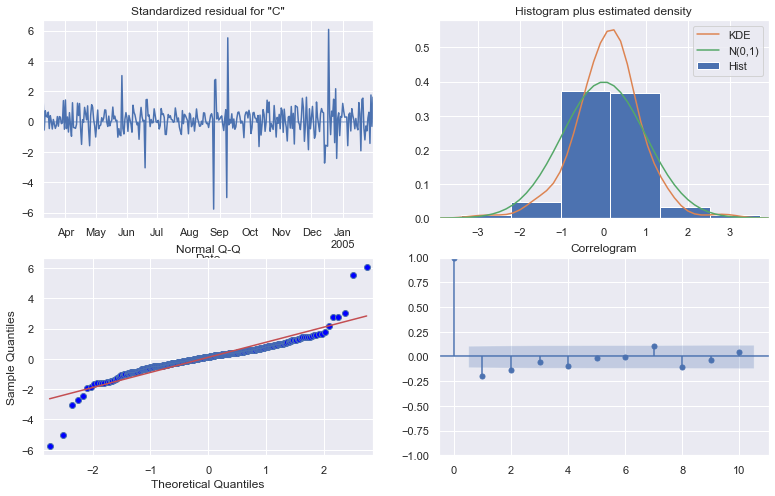

In [242]:
diagnostics[0]

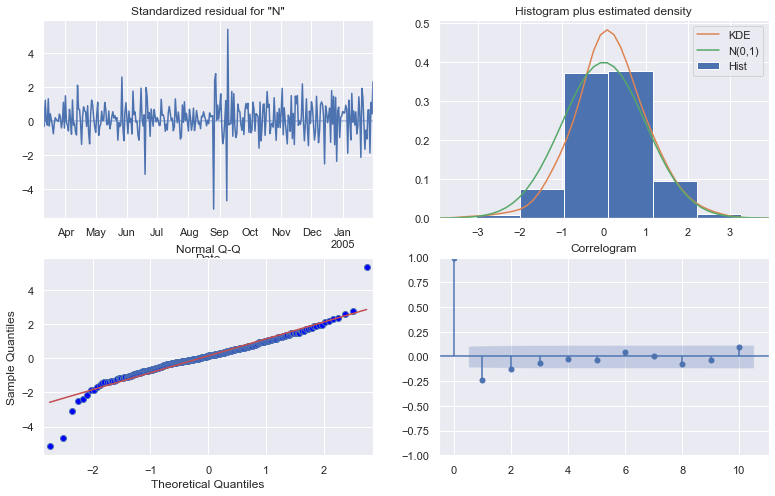

In [243]:
diagnostics[1]

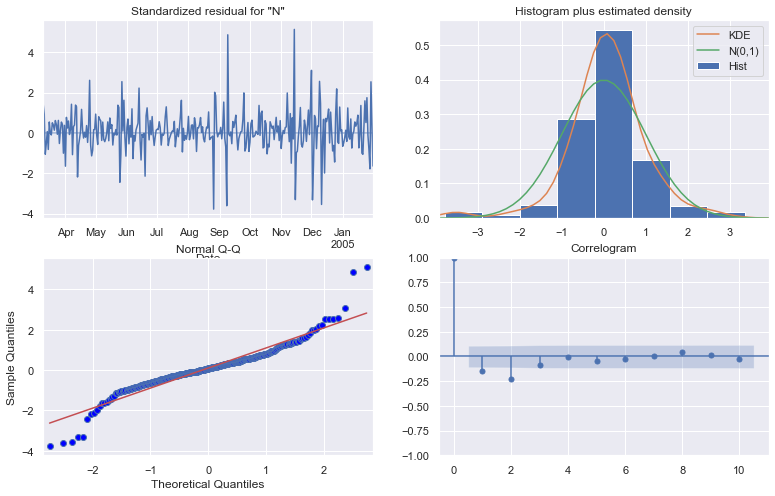

In [244]:
diagnostics[2]

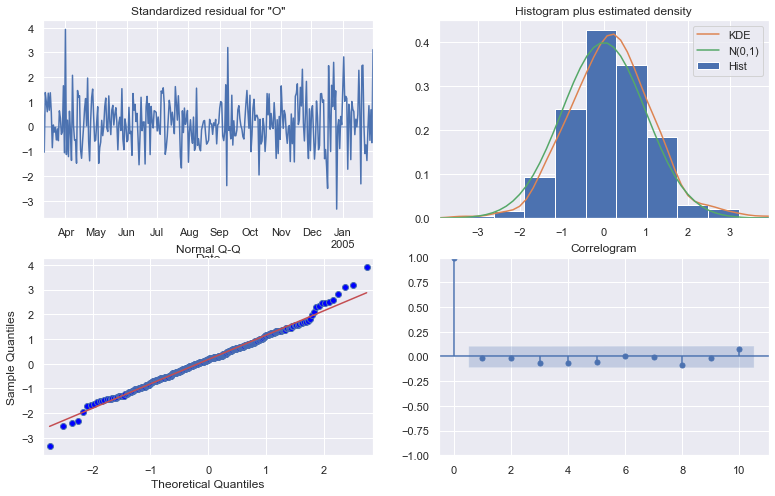

In [245]:
diagnostics[3]

#### Hyperparameter Tuning

##### Best Order

##### CO

In [246]:
def get_param_grid(data, gas,param_grid):
    data = data[gas]
    # Select order of differencing
    ## Try seasonal differencing
#     d = param_grid['d']
#     if 'D' in param_grid:
#         D = param_grid['D']
#     if 'D' in param_grid:
#         for i in param_grid['D']:
#             kpss_result = kpss(diff(data, i))
#             if kpss_result[0] >= 0.05: # if seasonal difference is stationary
#                 D = i
#                 break
          
#     ## Try first difference
#     for i in param_grid['d']:
#         kpss_result = kpss(diff(data, i + D))
#         if kpss_result[0] >= 0.05:
#             d = i
#             break

    orders = [
        (p, d, q) for p in param_grid['p'] for q in param_grid['q'] for d in param_grid['d']
    ]

    if 'P' in param_grid and 'Q' in param_grid and 'm' in param_grid:
        seasonal_orders = [
        (P, D, Q, m) for P in param_grid['P'] for Q in param_grid['Q'] for m in param_grid['m'] for D in param_grid['D']
    ]
    else:
        seasonal_orders = [None]

    if 'trend' in param_grid:
       trends = param_grid['trend']
    else:
        trends = ['n'] 
    
    exogs = param_grid['exog']
    return [              {
                        'order' : order,
                        'seasonal_order' : seasonal_order,
                        'trend' : trend,
                        'exog' : exog
                    } for order in orders for seasonal_order in seasonal_orders for trend in trends for exog in exogs
]

In [247]:
def score_aic(data, param, model):
    try:
        cur_model = model(data, **param).fit()
        # cur_model.save(name)
        aicc = cur_model.aicc
    except:
        aicc = np.inf
    return aicc 

In [248]:
def score_cv(data, param, model):
    try:
        cur_model, cv_metrics = eval_model(model, data, model_params=param, refit=False)
        # cur_model.save(name)
    except:
        return np.inf, np.inf
    return np.mean(cv_metrics['Test RMSE']), np.mean(cv_metrics['Difference in RMSE'])

In [249]:
from joblib import Parallel, delayed

def grid_search(data, gas,param_grid,model = SARIMAX):
    """
    Performs a grid search on SARIMAX parameters
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
#         warnings.simplefilter("error", UserWarning) # throw warning for non-invertible/stationary models
#         if exog:
#             file_names = [generate_file_name(f"SARIMAX-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMAX") for params in param_grid]
#         else:
#             file_names = [generate_file_name(f"SARIMA-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMA") for params in param_grid]
        parallel_instance = Parallel(n_jobs=-1, verbose=5)
        tasks = (
            delayed(score_cv)(data, param, model) for param in param_grid
        )
        rmse, rmse_diff = tuple(zip(*parallel_instance(tasks)))
    rmse = np.array(rmse)
    rmse_diff = np.array(rmse_diff)
    param_grid = np.array(param_grid)
    best_models = np.argsort(rmse)
    return pd.DataFrame({
        "Test RMSE" : rmse,
        "Difference in RMSE" : rmse_diff,
        "Order" : [param['order'] for param in param_grid],
        "Seasonal Order" :  [param['seasonal_order'] for param in param_grid],
        "Trend" :  [param['trend'] for param in param_grid],
        "Exog?" :  [param['exog'] is not None for param in param_grid]
    }).sort_values(["Test RMSE", "Difference in RMSE"])



In [250]:
# Hypertune a SARIMAX model
CO_ParamGrid = get_param_grid(train, 'CO', {
    'p' : range(5),
    'P' : range(5),
    'd' : [0],
    'D' : [0],
    'q' : range(5),
    'Q' : range(5),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [train[['T','RH']]]
})

co_gs_results = grid_search(train['CO'], 'CO', param_grid=CO_ParamGrid)
co_gs_results.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | e

Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
1701  158.678725          -45.040174  (1, 0, 0)   (3, 0, 1, 7)     c   True
739   160.180970           16.788436  (0, 0, 2)   (2, 0, 1, 7)     n   True
1917  161.361645          -43.563143  (1, 0, 1)   (1, 0, 4, 7)     c   True
3201  162.075700          -44.816162  (2, 0, 0)   (3, 0, 1, 7)     c   True
979   162.387822            1.548186  (0, 0, 3)   (1, 0, 1, 7)     n   True

In [251]:
co_gs_results.head()

Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
1701  158.678725          -45.040174  (1, 0, 0)   (3, 0, 1, 7)     c   True
739   160.180970           16.788436  (0, 0, 2)   (2, 0, 1, 7)     n   True
1917  161.361645          -43.563143  (1, 0, 1)   (1, 0, 4, 7)     c   True
3201  162.075700          -44.816162  (2, 0, 0)   (3, 0, 1, 7)     c   True
979   162.387822            1.548186  (0, 0, 3)   (1, 0, 1, 7)     n   True

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Test RMSE', ylabel='Difference in RMSE'>

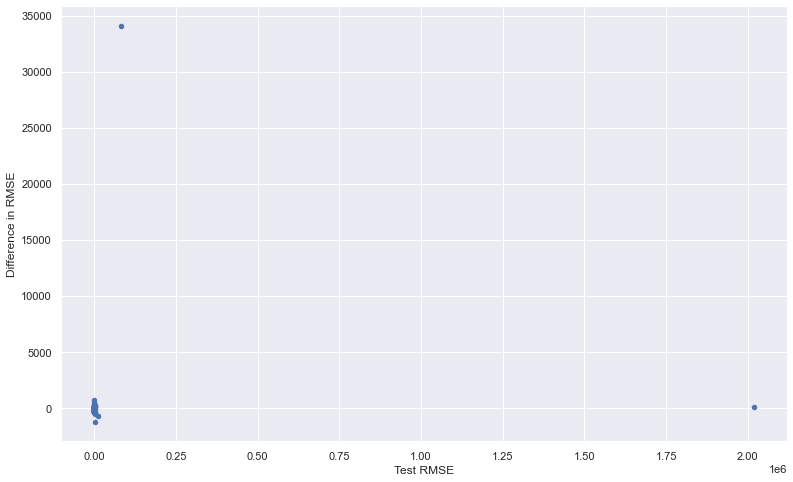

In [252]:
co_gs_results[['Test RMSE', 'Difference in RMSE']].plot(kind='scatter', x='Test RMSE', y='Difference in RMSE')

Based off the grid search, an order of (1, 1, 1) would be most appropriate. Given the lack of seasonal strength, I will pick the (0,0,0,0) seasonal order, given it has a similar RMSE, and lower degree of overfitting

In [253]:
# Hypertune a SARIMAX model
NMHC_ParamGrid = get_param_grid(train, 'NMHC', {
    'p' : range(5),
    'P' : range(4),
    'd' : [0],
    'D' : [0],
    'q' : range(5),
    'Q' : range(4),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [train[['T','RH']]]
})

nmhc_gs_results = grid_search(train['NMHC'], 'NMHC', param_grid=NMHC_ParamGrid)
nmhc_gs_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 18.0min finished


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
951   147.775519          -14.912300  (1, 0, 4)   (3, 0, 2, 7)     n   True
1019  149.869567          -39.637868  (2, 0, 0)   (2, 0, 1, 7)    ct   True
183   151.404760           23.700918  (0, 0, 1)   (3, 0, 2, 7)     n   True
2289  152.586264          -24.965300  (4, 0, 3)   (3, 0, 1, 7)     n   True
1053  152.832074          -18.961079  (2, 0, 0)   (3, 0, 3, 7)     n   True
...          ...                 ...        ...            ...   ...    ...
2389         inf                 inf  (4, 0, 4)   (3, 0, 2, 0)     c   True
2390         inf                 inf  (4, 0, 4)   (3, 0, 2, 0)    ct   True
2394         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)     n   True
2395         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)     c   True
2396         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)    ct   True

[2400 rows x 6 columns]

From looking at the grid search results, it seems that the (2, 1, 1) order (1,0,1,7) seasonal order would be a good fit to the data.

In [256]:
# Hypertune a SARIMAX model
NOx_ParamGrid = get_param_grid(train, 'NOx', {
    'p' : range(5),
    'P' : range(4),
    'd' : [0],
    'D' : [0],
    'q' : range(5),
    'Q' : range(4),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [train[['T','RH']]]
})

nox_gs_results = grid_search(train['NOx'], 'NOx', param_grid=NOx_ParamGrid)
nox_gs_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 894 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1164 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 2190 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 17.9min finished


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
1377  167.196831           -5.973599  (2, 0, 4)   (1, 0, 1, 7)     n   True
1287  170.612445          -11.412619  (2, 0, 3)   (1, 0, 2, 7)     n   True
1773  170.916600          -14.361425  (3, 0, 3)   (1, 0, 3, 7)     n   True
705   171.184129          -16.767797  (1, 0, 2)   (1, 0, 1, 7)     n   True
1215  171.360816          -17.678893  (2, 0, 2)   (2, 0, 2, 7)     n   True
...          ...                 ...        ...            ...   ...    ...
2389         inf                 inf  (4, 0, 4)   (3, 0, 2, 0)     c   True
2390         inf                 inf  (4, 0, 4)   (3, 0, 2, 0)    ct   True
2394         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)     n   True
2395         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)     c   True
2396         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)    ct   True

[2400 rows x 6 columns]

Here, we observe the model that appears to generalise well to the data is a (2, 1, 2) order and (1, 0, 1, 7) seasonal order

In [258]:
O3_ParamGrid = get_param_grid(train, 'O3', {
    'p' : range(5),
    'P' : range(4),
    'd' : [0],
    'D' : [0],
    'q' : range(5),
    'Q' : range(4),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [train[['T','RH']]]
})

o3_gs_results = grid_search(train['O3'], 'O3', param_grid=O3_ParamGrid)
o3_gs_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 894 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1164 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2190 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 17.8min finished


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
665   255.964234          -88.512992  (1, 0, 1)   (3, 0, 2, 7)    ct   True
635   257.076478          -91.990716  (1, 0, 1)   (2, 0, 1, 7)    ct   True
1346  261.747295          -71.234890  (2, 0, 4)   (0, 0, 0, 0)    ct   True
1349  261.747295          -71.234890  (2, 0, 4)   (0, 0, 0, 7)    ct   True
447   262.509308          -57.953912  (0, 0, 4)   (2, 0, 2, 7)     n   True
...          ...                 ...        ...            ...   ...    ...
2389         inf                 inf  (4, 0, 4)   (3, 0, 2, 0)     c   True
2390         inf                 inf  (4, 0, 4)   (3, 0, 2, 0)    ct   True
2394         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)     n   True
2395         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)     c   True
2396         inf                 inf  (4, 0, 4)   (3, 0, 3, 0)    ct   True

[2400 rows x 6 columns]

##### Hypertuned Order
| Gas | Order | Seasonal Order | Trend |
|---|---|---|---|
|CO| (0,0,3) | (1,0,1,7) | n|
|NMHC|(1,0,4) | (3, 0, 2, 7) | n|
|NOx|(2, 0, 4) | (1, 0, 1, 7) | n |
|O3|(0,0,4) | (2, 0, 2, 7) | n |

In [259]:
seasonal_orders = {
    "CO" : (1, 0, 1, 7),
    "NMHC" :  (3, 0, 2,7),
    "NOx" :  (1, 0, 2,7),
    "O3" :  (2, 0, 2,7)
}
orders = {
    "CO" : (0, 0, 3),
    "NMHC" : (1, 0, 4),
    "NOx" : (2, 0, 4),
    "O3" : (0, 0, 4)
}

trends = {
    "CO" : 'n',
    "NMHC" :"n",
    "NOx" : "n",
    "O3" : "n"
}
SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        trend = trends[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        exog = train[['T', 'RH']]
        try:
            final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend})
        except:
            final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend, 'initialization' : 'approximate_diffuse'})
        SARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
        sarimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", cv_metrics, gas)
results = parse_results(SARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.85s/it]


In [260]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2087.118022  1081.759560   750.429499   
     Train RMSE            5.0   164.022635    29.628133   138.538039   
     Test RMSE             5.0   162.477846    67.355825    79.347827   
     Difference in RMSE    5.0     1.544789    86.229275   -91.994678   
     Final AICc            5.0  4200.530293     0.000000  4200.530293   
NMHC Corrected AIC         5.0  2077.959583  1065.315600   741.564722   
     Train RMSE            5.0   133.774285    15.093599   113.534780   
     Test RMSE             5.0   150.570770    43.370460    90.058885   
     Difference in RMSE    5.0   -16.796484    55.915944   -96.548592   
     Final AICc            5.0  4164.201281     0.000000  4164.201281   
NOx  Corrected AIC         5.0  2124.036741  1081.928368   759.249702   
     Train RMSE            5.0   158.789332    13.071950   144.307342   
     Test RMSE             5.0   177.651893    51.143947    98.683174   
     Difference in RMSE    5.0   -18.862561    61.733584   -83.920318   
     Final AICc            5.0  4225.103117     0.000000  4225.103117   
O3   Corrected AIC         5.0  2204.412693  1108.011708   817.434589   
     Train RMSE            5.0   204.993060    31.775668   182.280463   
     Test RMSE             5.0   259.453421    96.498641   166.001919   
     Difference in RMSE    5.0   -54.460361   123.638967  -196.718239   
     Final AICc            5.0  4446.365398     0.000000  4446.365398   

                                 25%          50%          75%          max  
CO   Corrected AIC       1402.867044  2007.273881  2811.275007  3463.744679  
     Train RMSE           145.860489   158.208340   163.504650   214.001656  
     Test RMSE            132.514149   136.918696   225.753390   237.855167  
     Difference in RMSE   -87.215351    25.694191    77.082960    84.156823  
     Final AICc          4200.530293  4200.530293  4200.530293  4200.530293  
NMHC Corrected AIC       1432.799754  2005.176010  2771.994669  3438.262760  
     Train RMSE           126.910288   133.100839   141.819735   153.505785  
     Test RMSE            136.334198   157.239033   159.138362   210.083371  
     Difference in RMSE   -32.228074   -24.138194    17.171587    51.760850  
     Final AICc          4164.201281  4164.201281  4164.201281  4164.201281  
NOx  Corrected AIC       1469.293819  2087.079700  2781.464390  3523.096096  
     Train RMSE           147.527784   158.572640   169.540175   173.998720  
     Test RMSE            158.378569   192.503141   210.466919   228.227660  
     Difference in RMSE   -51.894279   -44.975357    15.620150    70.857001  
     Final AICc          4225.103117  4225.103117  4225.103117  4225.103117  
O3   Corrected AIC       1506.930122  2174.388066  2898.238186  3625.072499  
     Train RMSE           182.453489   186.117851   219.701000   254.412499  
     Test RMSE            170.815775   243.838194   337.439492   379.171727  
     Difference in RMSE  -155.159029   -57.720344    53.699081    83.596724  
     Final AICc          4446.365398  4446.365398  4446.365398  4446.365398

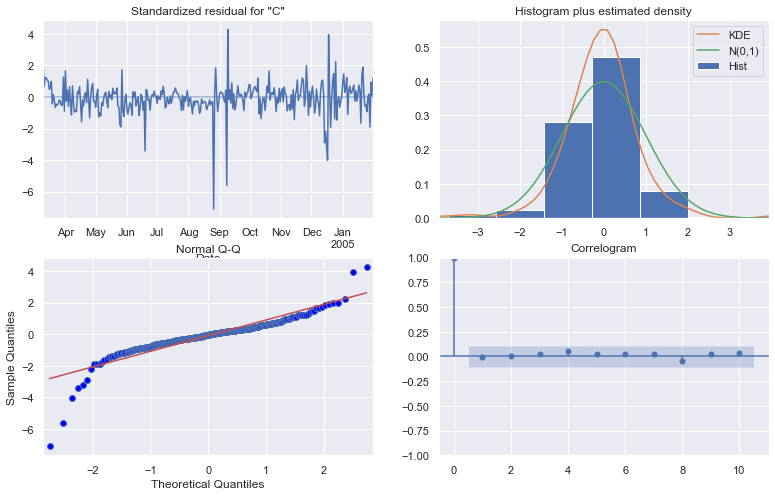

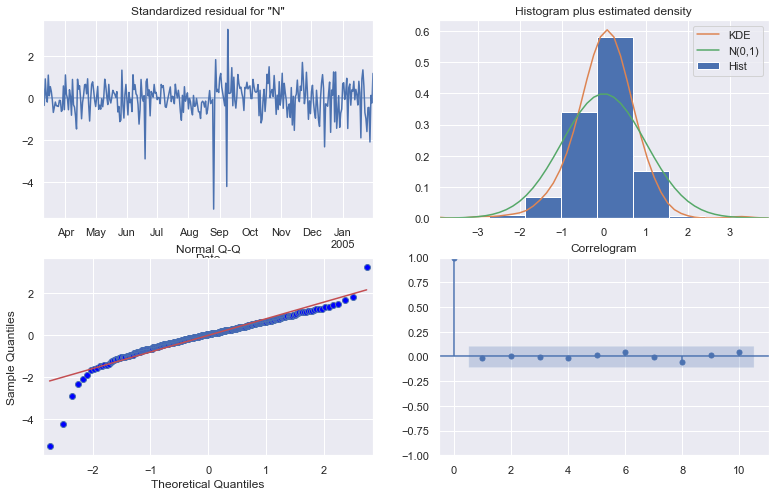

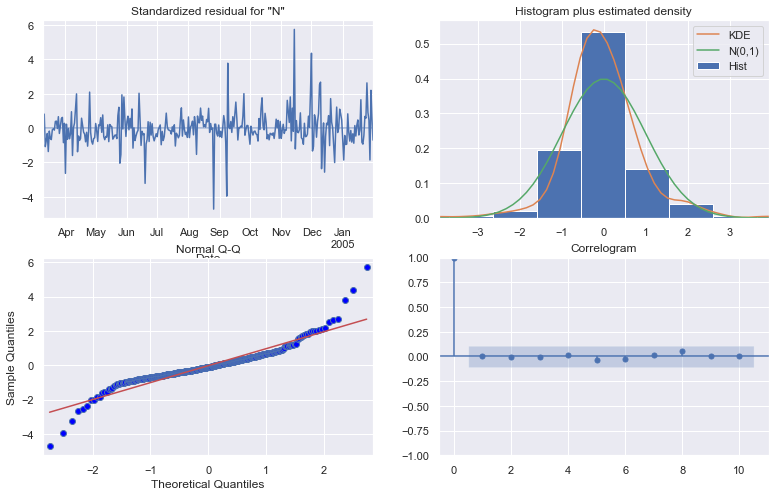

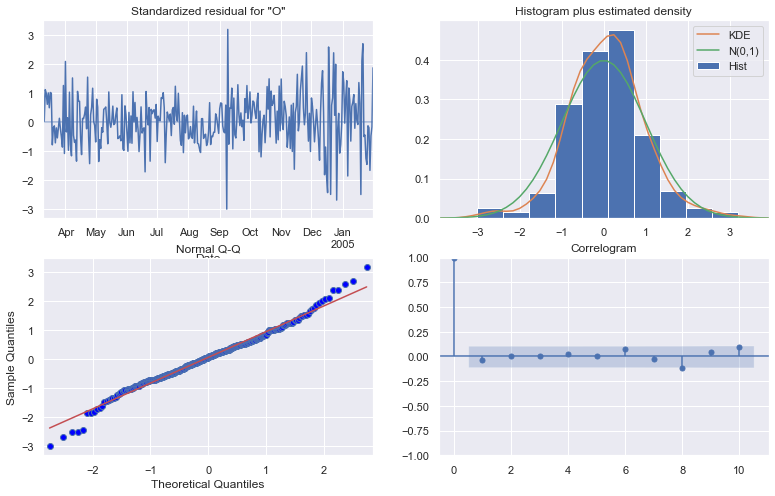

In [261]:
# %%capture 
# ^suppress output
models = [load(file) for file in sarimax_file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]

In [146]:
diagnostics

[<Figure size 936x576 with 4 Axes>,
 <Figure size 936x576 with 4 Axes>,
 <Figure size 936x576 with 4 Axes>,
 <Figure size 936x576 with 4 Axes>]

In [268]:
history.sort_values(['Gas', 'Mean Test RMSE'])

Model Name  Mean Test RMSE  Difference in RMSE  \
0    SARIMAX-(0, 0, 2)-(2, 0, 1, 7)-CO-n      160.363864          -84.526103   
1  SARIMAX-(0, 0, 1)-(3, 0, 2, 7)-NMHC-n      150.846075           -9.310593   
2   SARIMAX-(2, 0, 3)-(1, 0, 2, 7)-NOx-n     1288.890008          -42.679408   
3    SARIMAX-(0, 0, 2)-(3, 0, 1, 7)-O3-n      263.024617         -185.942952   

    Final AICc   Gas  
0  4213.333360    CO  
1  4167.731258  NMHC  
2  4227.203254   NOx  
3  4442.508117    O3

#### Using Weekend as Feature

#### Filtering Out Noise in the Data

#### Treatment of Outliers

## Final Model

### Analysis of Order

### Analysis of Residuals

## Generating Kaggle Predictions

In [355]:
test_df = pd.read_csv("test.csv", index_col=0, na_values=[-200])
test_df["Date"] = pd.to_datetime(test_df["Date"], format="%d/%m/%Y")
test_df.index = test_df["Date"]
test_df = test_df.drop("Date", axis=1)

In [358]:
test_df.head(12)

T          RH Gas
Date                                  
2005-02-01    6.616667   51.734375  CO
2005-02-02    7.613194   43.930903  CO
2005-02-03    7.252083   50.966667  CO
2005-02-04    7.473611   50.166319  CO
2005-02-05    5.571875   46.604167  CO
2005-02-06    5.310417   39.594792  CO
2005-02-07    7.307986   35.396875  CO
2005-02-08  -52.136458  -32.741667  CO
2005-02-09         NaN         NaN  CO
2005-02-10         NaN         NaN  CO
2005-02-11 -174.005208 -168.239583  CO
2005-02-12    8.306944   59.144791  CO

In [357]:
test, missing_days = DataPreprocess(test_df, train=False, remove_outliers=True, impute=True)

In [360]:
missing_days.head(12)

Date
2005-02-01    False
2005-02-02    False
2005-02-03    False
2005-02-04    False
2005-02-05    False
2005-02-06    False
2005-02-07    False
2005-02-08    False
2005-02-09     True
2005-02-10     True
2005-02-11    False
2005-02-12    False
dtype: bool

### Utility Functions

In [361]:
test[missing_days]

T         RH   Gas
Date                                 
2005-02-09  7.707569  44.896042    CO
2005-02-10  7.907361  49.645625    CO
2005-02-09  7.707569  44.896042  NMHC
2005-02-10  7.907361  49.645625  NMHC
2005-02-09  7.707569  44.896042   NOx
2005-02-10  7.907361  49.645625   NOx
2005-02-09  7.707569  44.896042    O3
2005-02-10  7.907361  49.645625    O3

In [362]:
def generate_csv(test_preds, missing_days):
    test_preds = np.array(test_preds).flatten()
    submit_df = pd.DataFrame({
    'id' : range(len(test_preds)),
    'Value' : test_preds
})
    submit_df.iloc[missing_days, 1] = -200 # replace days where sensor records were missing with -200 (NaN)
    submit_df.to_csv(generate_file_name("submission", "csv", "submissions", date=True), index=False)

In [295]:
# def generate_submission(models, test, missing_days, refit=True):
#     preds = []
#     for gas in gases:
#         model = load(models[gas])
#         data = test[test['Gas'] == gas]
# #         data.index = data['Date']
#         data = data.asfreq("D")
#         forecasts = []
#         start, end = data.index[0], data.index[-1]
#         for date in pd.date_range(start, end):
#             exog = data[['T', 'RH']].loc[date:date]
#             try:
#                 forecast = model.predict(start=date, exog=exog)
#                 forecast.name = gas
#                 model = model.append(forecast, exog=exog, refit=refit)
#             except:
#                 forecast = model.predict(start=date)
#                 forecast.name = gas
#                 model = model.append(forecast, refit=refit)
#             forecasts.append(forecast)
#         preds.append(forecasts)

#     generate_csv(preds, missing_days)
#     return preds

### Submission

In [264]:
sarimax_file_names

['models/SARIMAX/SARIMAX-(0, 0, 3)-(1, 0, 1, 7)-CO-n.pkl',
 'models/SARIMAX/SARIMAX-(1, 0, 4)-(3, 0, 2, 7)-NMHC-n.pkl',
 'models/SARIMAX/SARIMAX-(2, 0, 4)-(1, 0, 2, 7)-NOx-n.pkl',
 'models/SARIMAX/SARIMAX-(0, 0, 4)-(2, 0, 2, 7)-O3-n.pkl']

In [267]:
models = {
    "CO" : "models/SARIMAX/SARIMAX-(0, 0, 3)-(1, 0, 1, 7)-CO-n.pkl",
    "NMHC" : "models/SARIMAX/SARIMAX-(1, 0, 4)-(3, 0, 2, 7)-NMHC-n.pkl",
    "NOx" : "models/SARIMAX/SARIMAX-(2, 0, 4)-(1, 0, 2, 7)-NOx-n.pkl",
    "O3" : "models/SARIMAX/SARIMAX-(0, 0, 4)-(2, 0, 2, 7)-O3-n.pkl"
}

In [277]:
co = 
co

T         RH Gas
Date                                
2005-02-01   6.616667  51.734375  CO
2005-02-02   7.613194  43.930903  CO
2005-02-03   7.252083  50.966667  CO
2005-02-04   7.473611  50.166319  CO
2005-02-05   5.571875  46.604167  CO
...               ...        ...  ..
2005-03-31  17.554167  50.092708  CO
2005-04-01  15.919792  35.959722  CO
2005-04-02  15.489583  32.213542  CO
2005-04-03  18.381250  33.686458  CO
2005-04-04  16.966667  42.791667  CO

[63 rows x 3 columns]

In [320]:
pred

2005-02-01    1289.688818
2005-02-02    1075.690326
2005-02-03    1059.074559
2005-02-04     980.392961
2005-02-05     976.312599
                 ...     
2005-03-31    1030.372640
2005-04-01     945.738991
2005-04-02     951.558776
2005-04-03     799.692706
2005-04-04    1075.640298
Freq: D, Name: O3, Length: 63, dtype: float64

In [363]:
forecast = []
for gas in gases:
    model = load(models[gas])
    exog = test[test['Gas'] == gas][['T', 'RH']]
    pred = model.predict(start='2005-02-01', end='2005-04-04', exog=exog)
    pred.name = gas
    forecast.append(pred)
generate_csv(forecast, missing_days)

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



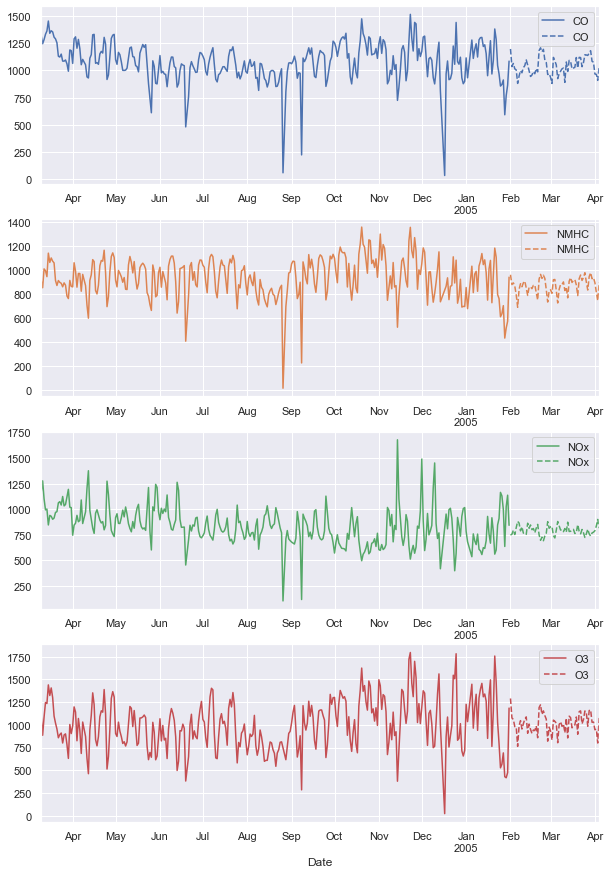

In [364]:
plot_predictions(train, forecast)

In [311]:
def plot_predictions(data, preds):
    fig, ax = plt.subplots(4, 1, figsize=(10, 15))
    preds_df = pd.DataFrame({
   series.name :series for series in preds
})
    data[['CO', 'NMHC', 'NOx', 'O3']].plot(subplots=True, ax=ax)
    preds_df.plot(subplots=True, ax =ax, style='--')